In [1]:
import pandas as pd
import argparse
import os
import math
import numpy as np
from random import randint
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import tree, svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, matthews_corrcoef, plot_roc_curve, plot_precision_recall_curve, confusion_matrix  
from imblearn.over_sampling import (
    RandomOverSampler,
    SMOTE,
    ADASYN,
    BorderlineSMOTE,
    SVMSMOTE
)
from sklearn.svm import SVC

In [26]:
%matplotlib inline

In [27]:
datasets_dir = './final_datasets2/'

In [28]:
save_dir = './final_datasets2/v2_1.0'

In [29]:
dataset_paths = [os.path.join(datasets_dir, file_name) for file_name in os.listdir(datasets_dir) if file_name.endswith('.csv')]
dataset_names = [file_name.split('.')[0] for file_name in os.listdir(datasets_dir) if file_name.endswith('.csv')]

In [30]:
dataset_paths

['./final_datasets2/ecoli1.csv',
 './final_datasets2/ecoli4.csv',
 './final_datasets2/vehicle0.csv',
 './final_datasets2/vehicle1.csv']

In [31]:
dataset_names

['ecoli1', 'ecoli4', 'vehicle0', 'vehicle1']

# Zmiana parametru stopnia niezrównoważenia

In [32]:
sampling_strategy = 1.0

## Słownik algorytmów oversamplingu

In [33]:
oversampler_dict = {

    'Random_Oversampling': RandomOverSampler(
        sampling_strategy=sampling_strategy,
        random_state=0),

    'SMOTE': SMOTE(
        sampling_strategy=sampling_strategy, 
        random_state=0,  
        k_neighbors=5),

    'ADASYN': ADASYN(
        sampling_strategy=sampling_strategy,  
        random_state=0,  
        n_neighbors=5),

    'SVM_SMOTE': SVMSMOTE(
        sampling_strategy=sampling_strategy,  
        random_state=0, 
        k_neighbors=5,
        m_neighbors=10,
        svm_estimator=SVC(kernel='linear')),
    'Borderline SMOTE1': BorderlineSMOTE(
        sampling_strategy=sampling_strategy,  
        random_state=0,  
        k_neighbors=5,
        m_neighbors=10,
        kind='borderline-1',
        n_jobs=4),
    'BorderLine SMOTE2': BorderlineSMOTE(
        sampling_strategy=sampling_strategy,  
        random_state=0,  
        k_neighbors=5,
        m_neighbors=10,
        kind='borderline-2',
        n_jobs=4), 
}

## Redukcja wymiarowości - algorytm PCA

### Wykreślanie rozkładu klas

In [34]:
def plot_decrease_dimension(X_r, y, dataset_name, title, file_name):
    fig, axes = plt.subplots(figsize=(10,7))
    axes.set_title(f"Zbiór danych: {dataset_name} {title} ")
    for c, i, target_name in zip("rgb", [0, 1], target_names):
        plt.scatter(X_r[y == i, 0], X_r[y == i, 1], c=c,
                    label=target_name)
    axes.legend(loc="upper left")
    fig.savefig(os.path.join(save_dir, f"{dataset_name}_{file_name}.jpg"))

### Przeprowadzenie redukcji wymiarowości

In [35]:
def decrease_dimension(X):
    pca = PCA(n_components=2)
    X_r = pca.fit_transform(X)
    print('Współczynnik wyjaśnianej wariancji dla 2 komponentów: %s'
          % str(pca.explained_variance_ratio_))
    return X_r

# Klasyfikatory

### Słownik klasyfikatorów

In [36]:
models = {
    "Tree" : tree.DecisionTreeClassifier(criterion='gini'),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=0),
    "LogisticRegression": LogisticRegression(random_state=0,  max_iter=1000),
    "NaiveBayes": GaussianNB(),
    "SVM_Linear": svm.SVC(kernel="linear"),
    "SVM_RBF": svm.SVC(kernel="rbf"),
    "SVM_Polymonial": svm.SVC(kernel="poly")
}

### Trening klasyfikatorów

In [37]:
def run_classifiers(X_train, X_test, y_train, y_test, dataset_name):
    predictions = {}
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)
        predictions[model_name] = y_test_pred
    return predictions

### Ensamble methods - dodanie kolumny z głosowaniem większościowym

In [38]:
def create_ensemble_decision(predictions_dict):
    initial_predictions_df = pd.DataFrame.from_dict(predictions_dict)
#     initial_predictions_df['sum_1'] = (initial_predictions_df[['Tree', 'RandomForest', 'LogisticRegression', 'NaiveBayes', 'SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
#     initial_predictions_df['sum_0'] = (initial_predictions_df[['Tree', 'RandomForest', 'LogisticRegression', 'NaiveBayes', 'SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
    ensemble_predictions_df = initial_predictions_df.loc[:, initial_predictions_df.columns != 'RandomForest']
    svm_predictions_df = initial_predictions_df.loc[:, (initial_predictions_df.columns != 'RandomForest') & (initial_predictions_df.columns != 'Tree') & (initial_predictions_df.columns != 'NaiveBayes') & (initial_predictions_df.columns != 'LogisticRegression')]
    rest_predictions_df = initial_predictions_df.loc[:, (initial_predictions_df.columns != 'SVM_Linear') & (initial_predictions_df.columns != 'SVM_RBF') & (initial_predictions_df.columns != 'RandomForest') & (initial_predictions_df.columns != 'SVM_Polymonial')]
    ensemble_predictions_df['sum_1'] = (ensemble_predictions_df[['Tree', 'LogisticRegression', 'NaiveBayes', 'SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
    ensemble_predictions_df['sum_0'] = (ensemble_predictions_df[['Tree', 'LogisticRegression', 'NaiveBayes', 'SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
    svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
    svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
    rest_predictions_df['sum_1'] = (rest_predictions_df[['Tree', 'LogisticRegression', 'NaiveBayes']] == 1).sum(axis=1)
    rest_predictions_df['sum_0'] = (rest_predictions_df[['Tree', 'LogisticRegression', 'NaiveBayes']] == 0).sum(axis=1)
    ensemble_predictions_df['Ensemble_methods'] = np.where(ensemble_predictions_df['sum_1'] > ensemble_predictions_df['sum_0'], 1, 0)  
    svm_predictions_df['Ensemble_methods'] = np.where(svm_predictions_df['sum_1'] > svm_predictions_df['sum_0'], 1, 0)
#     initial_predictions_df['Ensemble_methods'] = np.where(initial_predictions_df['sum_1'] > initial_predictions_df['sum_0'], 1, 0)
    rest_predictions_df['Ensemble_methods'] = np.where(rest_predictions_df['sum_1'] > rest_predictions_df['sum_0'], 1, 0)
    equal_indices = ensemble_predictions_df.index[ensemble_predictions_df['sum_1'] == ensemble_predictions_df['sum_0']].tolist()
    for index in equal_indices:
        ensemble_predictions_df.at[index, 'Ensemble_methods'] = randint(0,1)
    final_predictions_df = initial_predictions_df
    final_predictions_df['Ensemble_methods'] = ensemble_predictions_df['Ensemble_methods']
    final_predictions_df['SVM_ensemble'] = svm_predictions_df['Ensemble_methods']
#     final_predictions_df['All_ensemble'] = initial_predictions_df['Ensemble_methods']
    final_predictions_df['Tree_Logistic_naive_ensamble'] = rest_predictions_df['Ensemble_methods']
    return final_predictions_df

# Obliczenie metryk

In [39]:
def calculate_metrics(y_true, y_pred):
    metrics_dict = {}
    metrics_dict["Accuracy"] = round(accuracy_score(y_true, y_pred), 2)
    metrics_dict["Precision"] = round(precision_score(y_true, y_pred), 2)
    sensitivity=round(recall_score(y_true, y_pred), 2)
    metrics_dict["Recall - Sensitivity"] =  sensitivity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    specificity=tn/(tn+fp)
    metrics_dict["Specificity"] = round(specificity, 2)
    metrics_dict['G-Mean'] = round(math.sqrt(sensitivity*specificity), 2)
    metrics_dict['BalancedAccuracy'] = round(1/2 *(sensitivity+specificity), 2)
    metrics_dict["Roc-Auc score"] = round(roc_auc_score(y_true, y_pred), 2)
    metrics_dict["F1-score"] = round(f1_score(y_true, y_pred), 2)
    metrics_dict["Mattews Correlation Coefficient"] = round(matthews_corrcoef(y_true, y_pred), 2)
    metrics_series = pd.Series(metrics_dict)
    return metrics_series

### Wywołanie obliczania metryk

In [40]:
def run_calculate_metrics(y_test, predictions_dict):
    metrics_dict = {}
    metrics_dict["Tree"] = calculate_metrics(y_test, predictions_dict["Tree"])
    metrics_dict["RandomForest"] = calculate_metrics(y_test, predictions_dict["RandomForest"])
    metrics_dict["LogisticRegression"] = calculate_metrics(y_test, predictions_dict["LogisticRegression"])
    metrics_dict["NaiveBayes"] = calculate_metrics(y_test, predictions_dict["NaiveBayes"])
    metrics_dict["SVM_Linear"] = calculate_metrics(y_test, predictions_dict["SVM_Linear"])
    metrics_dict["SVM_RBF"] = calculate_metrics(y_test, predictions_dict["SVM_RBF"])
    metrics_dict["SVM_Polymonial"] = calculate_metrics(y_test, predictions_dict["SVM_Polymonial"])
#     metrics_dict["All_ensemble"] = calculate_metrics(y_test, predictions_dict["All_ensemble"])
    metrics_dict["Ensemble_methods"] = calculate_metrics(y_test, predictions_dict["Ensemble_methods"])
    metrics_dict["SVM_ensemble"] = calculate_metrics(y_test, predictions_dict["SVM_ensemble"])
    metrics_dict["Tree_Logistic_naive_ensamble"] = calculate_metrics(y_test, predictions_dict["Tree_Logistic_naive_ensamble"])
    metrics_df = pd.DataFrame.from_dict(metrics_dict)
    return metrics_df

### Wypisanie metryk

In [41]:
def print_metrics(metrics_df):
    metrics_full_df = pd.DataFrame()
    metrics_full_df['DecisionTree'] = metrics_df["Tree"]
    metrics_full_df['RandomForest'] =  metrics_df["RandomForest"]
    metrics_full_df['LogisticsRegression'] = metrics_df["LogisticRegression"]
    metrics_full_df['NaiveBayes'] = metrics_df["NaiveBayes"]
    metrics_full_df['SVM_Linear'] = metrics_df["SVM_Linear"]
    metrics_full_df['SVM_RBF'] = metrics_df["SVM_RBF"]
    metrics_full_df['SVM_Polymonial'] = metrics_df["SVM_Polymonial"]
#     metrics_full_df['All_ensemble'] = metrics_df["All_ensemble"]
    metrics_full_df['Ensemble_methods'] = metrics_df["Ensemble_methods"]
    metrics_full_df['SVM_ensemble'] = metrics_df["SVM_ensemble"]
    metrics_full_df['Tree_Logistic_naive_ensamble'] = metrics_df["Tree_Logistic_naive_ensamble"]
    print("-------------------------------------------------------")
    print(metrics_full_df)
    print("-------------------------------------------------------")

In [42]:
model_names = ['Tree', 'RandomForest', 'LogisticRegression', 'NaiveBayes', 'SVM_Linear', 'SVM_RBF', 'SVM_Polymonial', 'Ensemble_methods', 'SVM_ensemble', 'Tree_Logistic_naive_ensamble']

In [43]:
def create_metrics_summary(metrics_df, result_df, algorithm_name):
    for model in model_names:
        result_df.at[model, algorithm_name] = metrics_df.loc[:, model]
    return result_df

In [44]:
def create_metrics_dataframe(multiindex):
    result_dataframe = pd.DataFrame(columns=["Accuracy", "Precision", "Recall - Sensitivity", "Specificity",'G-Mean','BalancedAccuracy', 
                                             "Roc-Auc score","F1-score", "Mattews Correlation Coefficient" ], index=multiindex)
    return result_dataframe

### Tworzenie struktury do zapisu danych

In [45]:
def create_multiindex(algorithm_names):
    algorithm_list = list(algorithm_names)
    algorithm_list.insert(0, "Imbalanced")
    multiindex_names = [model_names, algorithm_list]
    multiindex_object = pd.MultiIndex.from_product(multiindex_names, names=["Klasyfikator", "Algorytm"])
    return multiindex_object

### Konwersja numpy array do pandas dataframe

In [46]:
def numpy_to_pandas(numpy_arr):
    df = pd.DataFrame(numpy_arr)
    return df

### Obliczanie statystyk zbiorów danych

In [47]:
def dataset_stats(y, df_stats, dataset_type, dataset_name):
    data_info = y.iloc[:,-1].value_counts()
    data_info_dict = data_info.to_dict()
    df_stats = df_stats.append({'Rodzaj zbioru': f"{dataset_type} {dataset_name}", '1':data_info_dict[1], '0': data_info_dict[0]}, ignore_index=True)
    return df_stats 

# Walidacja krzyżowa 

In [48]:
def cross_validation_raw_data(X_train, y_train, dataset_name, oversampler_name, dataset_stats_df):
    splits = 5
    cv = StratifiedKFold(n_splits=splits)
    for i, (train_fold_index, test_fold_index) in enumerate(cv.split(X_train,y_train)):
        X_train_fold, y_train_fold = X_train[train_fold_index], y_train[train_fold_index]
        X_test_fold, y_test_fold = X_train[test_fold_index], y_train[test_fold_index]
        if oversampler_name is not None:
            X_resampled, y_resampled = oversampler_dict[oversampl_key].fit_resample(X_train_fold, y_train_fold)
            df_y_train_resampled = numpy_to_pandas(y_resampled)
            dataset_stats_df = dataset_stats(df_y_train_resampled, dataset_stats_df, f"Zbior treningowy dla fold nr {i} zwielokrotniony {oversampl_key}", dataset_name)
            predictions_dict = run_classifiers(X_resampled, X_test_fold, y_resampled, y_test_fold, dataset_name)
            predictions_dict = create_ensemble_decision(predictions_dict)
            X_decreased = decrease_dimension(X_resampled)
            plot_decrease_dimension(X_decreased, y_resampled, dataset_name, f"Algorytm: {oversampler_name} Fold: {i}", f"balanced_train_{oversampler_name}_fold_{i}")
        else:
            predictions_dict = run_classifiers(X_train_fold, X_test_fold, y_train_fold, y_test_fold, dataset_name)
            predictions_dict = create_ensemble_decision(predictions_dict)
            df_y_train_fold = numpy_to_pandas(y_train_fold)
            dataset_stats_df = dataset_stats(df_y_train_fold, dataset_stats_df, f"Zbior treningowy dla fold nr {i}", dataset_name)
            df_y_test_fold = numpy_to_pandas(y_test_fold)
            dataset_stats_df = dataset_stats(df_y_test_fold, dataset_stats_df, f"Zbior testowy dla fold nr {i}", dataset_name)
            X_decreased = decrease_dimension(X_train_fold)
            plot_decrease_dimension(X_decreased, y_train_fold, dataset_name, f"Zbiór treningowy Fold: {i}", f"imbalanced_train_fold{i}")
        if i ==0 :
            metrics_df = run_calculate_metrics(y_test_fold, predictions_dict)
        else:
            result_df = run_calculate_metrics(y_test_fold, predictions_dict)
            metrics_df = metrics_df.add(result_df)
    metrics_df = metrics_df.div(splits)
    return metrics_df, dataset_stats_df

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.5161681 0.2442034]
Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.5161681 0.2442034]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.48782697 0.25661321]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.48594187 0.26034728]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.49368958 0.25928463]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.54315903 0.25487066]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.58806425 0.19777584]
********IMBALANCED METRICS********


Metrics for dataset: ecoli1 

-------------------------------------------------------
                                 DecisionTree  RandomForest  \
Accuracy                                0.864         0.870   
Precision                               0.748         0.822   
Recall - Sensitivity                    0.768         0.754   
Specificity                             0.890         0.904   
G-Mean                                  0.816         0.808   
BalancedAccuracy                        0.832         0.830   
Roc-Auc score                           0.830         0.830   
F1-score                                0.728         0.748   
Mattews Correlation Coefficient         0.668         0.700   

                                 LogisticsRegression  NaiveBayes  SVM_Linear  \
Accuracy                                       0.840       0.662       0.852   
Precisio

C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.51626561 0.22855422]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.48858301 0.2432042 ]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.52342279 0.22278787]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.56163857 0.21438216]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.5751713  0.19879983]
-------------------------------------------------------
                                 DecisionTree  RandomForest  \
Accuracy                                0.868         0.868   
Precision                               0.742         0.760   
Recall - Sensitivity                    0.778         0.848   
Specificity                             0.894         0.874   
G-Mean                                  0.826         0.850   
BalancedAccuracy                        0.840         0.862   
Roc-Auc score                           0.840         0.858   
F1-score                                0.738         0.774   
Mattews Correlation Coefficient         0.672         0.716   

                                 LogisticsRegression  NaiveBayes  SVM_Linear  \
Accuracy                                       0.848       0.586       0.850   
Precision                                      0.710       0.372       0.70

C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.50753526 0.24162934]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.5163601  0.23951794]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.55496519 0.21293751]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.60106121 0.20307409]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.62310568 0.19107014]
-------------------------------------------------------
                                 DecisionTree  RandomForest  \
Accuracy                                0.852         0.868   
Precision                               0.714         0.784   
Recall - Sensitivity                    0.818         0.820   
Specificity                             0.862         0.882   
G-Mean                                  0.832         0.838   
BalancedAccuracy                        0.842         0.852   
Roc-Auc score                           0.842         0.850   
F1-score                                0.736         0.772   
Mattews Correlation Coefficient         0.666         0.712   

                                 LogisticsRegression  NaiveBayes  SVM_Linear  \
Accuracy                                       0.854       0.694       0.852   
Precision                                      0.728       0.466       0.70

C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.54176748 0.21236648]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.53863047 0.21546306]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.5427683  0.21027905]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.57368497 0.19749538]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.62453033 0.17968163]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2332219128.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(figsize=(10,7))


-------------------------------------------------------
                                 DecisionTree  RandomForest  \
Accuracy                                0.850         0.862   
Precision                               0.706         0.754   
Recall - Sensitivity                    0.858         0.860   
Specificity                             0.850         0.862   
G-Mean                                  0.848         0.850   
BalancedAccuracy                        0.854         0.860   
Roc-Auc score                           0.854         0.862   
F1-score                                0.754         0.774   
Mattews Correlation Coefficient         0.682         0.712   

                                 LogisticsRegression  NaiveBayes  SVM_Linear  \
Accuracy                                       0.856       0.614       0.850   
Precision                                      0.706       0.398       0.696   
Recall - Sensitivity                           0.912       0.924       0.

C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.53151055 0.21681232]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.51915954 0.21854518]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.50999749 0.21743038]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.52104157 0.21427731]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.63077443 0.16959297]
-------------------------------------------------------
                                 DecisionTree  RandomForest  \
Accuracy                                0.854         0.874   
Precision                               0.742         0.772   
Recall - Sensitivity                    0.808         0.884   
Specificity                             0.868         0.870   
G-Mean                                  0.824         0.866   
BalancedAccuracy                        0.840         0.878   
Roc-Auc score                           0.838         0.878   
F1-score                                0.736         0.798   
Mattews Correlation Coefficient         0.674         0.742   

                                 LogisticsRegression  NaiveBayes  SVM_Linear  \
Accuracy                                       0.842       0.652       0.846   
Precision                                      0.696       0.434       0.69

C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.54434846 0.20411251]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.53926068 0.19841121]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.47117418 0.22278149]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.51396382 0.2138977 ]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.66312616 0.14866144]
-------------------------------------------------------
                                 DecisionTree  RandomForest  \
Accuracy                                0.858         0.872   
Precision                               0.708         0.786   
Recall - Sensitivity                    0.820         0.820   
Specificity                             0.868         0.884   
G-Mean                                  0.838         0.840   
BalancedAccuracy                        0.846         0.854   
Roc-Auc score                           0.844         0.854   
F1-score                                0.736         0.776   
Mattews Correlation Coefficient         0.670         0.718   

                                 LogisticsRegression  NaiveBayes  SVM_Linear  \
Accuracy                                       0.846       0.656       0.842   
Precision                                      0.698       0.422       0.68

C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.52935916 0.21145853]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.52636293 0.20018037]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.47104012 0.22178518]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.51370518 0.21847497]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.64322402 0.15649634]
-------------------------------------------------------
                                 DecisionTree  RandomForest  \
Accuracy                                0.814         0.868   
Precision                               0.638         0.750   
Recall - Sensitivity                    0.756         0.860   
Specificity                             0.830         0.868   
G-Mean                                  0.782         0.852   
BalancedAccuracy                        0.794         0.866   
Roc-Auc score                           0.794         0.864   
F1-score                                0.664         0.776   
Mattews Correlation Coefficient         0.568         0.718   

                                 LogisticsRegression  NaiveBayes  SVM_Linear  \
Accuracy                                       0.830       0.492       0.830   
Precision                                      0.670       0.322       0.66

C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.49468169 0.24957154]


C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.50008978 0.2465749 ]


C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.49530764 0.24924171]


C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.47160927 0.29701696]


C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.61439908 0.18066827]


C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


********IMBALANCED METRICS********


Metrics for dataset: ecoli4 

-------------------------------------------------------
                                 DecisionTree  RandomForest  \
Accuracy                                0.968         0.948   
Precision                               0.774         0.850   
Recall - Sensitivity                    0.800         0.700   
Specificity                             0.972         0.962   
G-Mean                                  0.876         0.796   
BalancedAccuracy                        0.888         0.830   
Roc-Auc score                           0.888         0.830   
F1-score                                0.750         0.666   
Mattews Correlation Coefficient         0.752         0.700   

                                 LogisticsRegression  NaiveBayes  SVM_Linear  \
Accuracy                                        0.94       0.824       0.940   
Precision                                       0.00       0.632       0.100   
Recall

C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.4182023  0.29211185]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.43169039 0.27088757]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.40470652 0.30158931]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.49310625 0.26915599]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.4269723  0.34547055]
-------------------------------------------------------
                                 DecisionTree  RandomForest  \
Accuracy                                0.962         0.972   
Precision                               0.792         0.888   
Recall - Sensitivity                    0.750         0.750   
Specificity                             0.972         0.984   
G-Mean                                  0.848         0.850   
BalancedAccuracy                        0.862         0.868   
Roc-Auc score                           0.862         0.868   
F1-score                                0.718         0.764   
Mattews Correlation Coefficient         0.728         0.780   

                                 LogisticsRegression  NaiveBayes  SVM_Linear  \
Accuracy                                       0.878       0.788       0.868   
Precision                                      0.698       0.486       0.76

C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.44937728 0.29402128]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.46432901 0.27436601]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.43452757 0.30815405]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.51983492 0.26610051]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.46878626 0.34419606]
-------------------------------------------------------
                                 DecisionTree  RandomForest  \
Accuracy                                0.952         0.938   
Precision                               0.778         0.834   
Recall - Sensitivity                    0.750         0.850   
Specificity                             0.962         0.940   
G-Mean                                  0.844         0.890   
BalancedAccuracy                        0.858         0.898   
Roc-Auc score                           0.858         0.898   
F1-score                                0.700         0.776   
Mattews Correlation Coefficient         0.712         0.786   

                                 LogisticsRegression  NaiveBayes  SVM_Linear  \
Accuracy                                       0.894       0.832       0.898   
Precision                                      0.780       0.632       0.77

C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.41161536 0.30119551]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.43452386 0.28103028]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.40642799 0.31002952]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.49478006 0.29551168]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.38597862 0.36460071]
-------------------------------------------------------
                                 DecisionTree  RandomForest  \
Accuracy                                0.966         0.968   
Precision                               0.872         0.872   
Recall - Sensitivity                    0.750         0.750   
Specificity                             0.978         0.978   
G-Mean                                  0.846         0.836   
BalancedAccuracy                        0.864         0.864   
Roc-Auc score                           0.864         0.864   
F1-score                                0.746         0.730   
Mattews Correlation Coefficient         0.766         0.756   

                                 LogisticsRegression  NaiveBayes  SVM_Linear  \
Accuracy                                       0.856       0.818       0.854   
Precision                                      0.670       0.552       0.64

C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.4294516  0.29892716]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.44543053 0.27353571]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.43058743 0.30363241]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.50128339 0.27810674]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.40435835 0.36261718]
-------------------------------------------------------
                                 DecisionTree  RandomForest  \
Accuracy                                0.952         0.970   
Precision                               0.708         0.862   
Recall - Sensitivity                    0.750         0.900   
Specificity                             0.962         0.972   
G-Mean                                  0.844         0.934   
BalancedAccuracy                        0.856         0.938   
Roc-Auc score                           0.856         0.938   
F1-score                                0.672         0.838   
Mattews Correlation Coefficient         0.678         0.846   

                                 LogisticsRegression  NaiveBayes  SVM_Linear  \
Accuracy                                       0.874       0.790       0.876   
Precision                                      0.738       0.492       0.72

C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.41777411 0.29969229]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.4454027  0.27715666]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.40904304 0.31561115]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.50052752 0.29791355]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.39990297 0.35293088]
-------------------------------------------------------
                                 DecisionTree  RandomForest  \
Accuracy                                0.966         0.972   
Precision                               0.872         0.880   
Recall - Sensitivity                    0.750         0.800   
Specificity                             0.978         0.980   
G-Mean                                  0.846         0.880   
BalancedAccuracy                        0.864         0.892   
Roc-Auc score                           0.864         0.892   
F1-score                                0.746         0.792   
Mattews Correlation Coefficient         0.766         0.804   

                                 LogisticsRegression  NaiveBayes  SVM_Linear  \
Accuracy                                       0.852       0.824       0.858   
Precision                                      0.610       0.632       0.68

C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.40034619 0.30286021]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.44436578 0.27319896]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.39622904 0.31551556]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.47366724 0.31753303]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.42324119 0.31395941]
-------------------------------------------------------
                                 DecisionTree  RandomForest  \
Accuracy                                0.886         0.936   
Precision                               0.554         0.786   
Recall - Sensitivity                    0.900         0.850   
Specificity                             0.882         0.938   
G-Mean                                  0.880         0.890   
BalancedAccuracy                        0.892         0.898   
Roc-Auc score                           0.892         0.898   
F1-score                                0.640         0.756   
Mattews Correlation Coefficient         0.642         0.762   

                                 LogisticsRegression  NaiveBayes  SVM_Linear  \
Accuracy                                       0.816       0.754       0.814   
Precision                                      0.514       0.424       0.53

C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.96003729 0.01782125]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.95834721 0.01811621]


C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.95989704 0.01781536]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.95968507 0.01777093]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.95804075 0.01866942]
********IMBALANCED METRICS********


Metrics for dataset: vehicle0 

-------------------------------------------------------
                                 DecisionTree  RandomForest  \
Accuracy                                0.926         0.974   
Precision                               0.840         0.932   
Recall - Sensitivity                    0.838         0.956   
Specificity                             0.948         0.976   
G-Mean                                  0.890         0.966   
BalancedAccuracy                        0.894         0.966   
Roc-Auc score                           0.894         0.964   
F1-score                                0.836         0.942   
Mattews Correlation Coefficient         0.790         0.922   

                                 LogisticsRegression  NaiveBayes  SVM_Linear  \
Accuracy                                       0.972       0.648       0.966   
Precis

C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.94877691 0.0246905 ]


C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.94425634 0.02700823]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.94896988 0.02508513]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.95477573 0.01970106]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.95002221 0.02335445]
-------------------------------------------------------
                                 DecisionTree  RandomForest  \
Accuracy                                0.938         0.970   
Precision                               0.872         0.912   
Recall - Sensitivity                    0.878         0.970   
Specificity                             0.956         0.970   
G-Mean                                  0.912         0.968   
BalancedAccuracy                        0.918         0.970   
Roc-Auc score                           0.918         0.970   
F1-score                                0.872         0.938   
Mattews Correlation Coefficient         0.834         0.918   

                                 LogisticsRegression  NaiveBayes  SVM_Linear  \
Accuracy                                       0.972       0.658       0.962   
Precision                                      0.920       0.402       0.89

C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.95518871 0.01998864]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.95171444 0.02092567]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.94974391 0.02377454]


C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.95079663 0.02328932]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.9462793 0.0264859]
-------------------------------------------------------
                                 DecisionTree  RandomForest  \
Accuracy                                0.934         0.968   
Precision                               0.870         0.904   
Recall - Sensitivity                    0.850         0.976   
Specificity                             0.962         0.968   
G-Mean                                  0.902         0.972   
BalancedAccuracy                        0.906         0.972   
Roc-Auc score                           0.904         0.972   
F1-score                                0.856         0.938   
Mattews Correlation Coefficient         0.814         0.918   

                                 LogisticsRegression  NaiveBayes  SVM_Linear  \
Accuracy                                       0.974       0.658       0.968   
Precision                                      0.926       0.402       0.920 

C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.94756492 0.02700873]


C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.94823727 0.02543972]


C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.94583579 0.02794436]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.94480528 0.02957524]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.95005892 0.02430404]
-------------------------------------------------------
                                 DecisionTree  RandomForest  \
Accuracy                                0.950         0.966   
Precision                               0.880         0.900   
Recall - Sensitivity                    0.914         0.976   
Specificity                             0.964         0.968   
G-Mean                                  0.936         0.970   
BalancedAccuracy                        0.938         0.970   
Roc-Auc score                           0.938         0.972   
F1-score                                0.896         0.936   
Mattews Correlation Coefficient         0.864         0.916   

                                 LogisticsRegression  NaiveBayes  SVM_Linear  \
Accuracy                                       0.968       0.646       0.964   
Precision                                      0.908       0.386       0.90

C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.94886749 0.02569862]


C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.94369588 0.03008273]


C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.93245842 0.0425945 ]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.94932583 0.02561563]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.94335986 0.03138533]
-------------------------------------------------------
                                 DecisionTree  RandomForest  \
Accuracy                                0.930         0.960   
Precision                               0.838         0.882   
Recall - Sensitivity                    0.874         0.966   
Specificity                             0.948         0.962   
G-Mean                                  0.910         0.962   
BalancedAccuracy                        0.910         0.962   
Roc-Auc score                           0.910         0.962   
F1-score                                0.854         0.922   
Mattews Correlation Coefficient         0.810         0.898   

                                 LogisticsRegression  NaiveBayes  SVM_Linear  \
Accuracy                                       0.956       0.644       0.958   
Precision                                      0.858       0.372       0.85

C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.93324148 0.0393325 ]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.93432772 0.03895816]


C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.91595514 0.05752533]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.92477475 0.04898487]


C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.90999068 0.06202396]
-------------------------------------------------------
                                 DecisionTree  RandomForest  \
Accuracy                                0.944         0.964   
Precision                               0.846         0.894   
Recall - Sensitivity                    0.930         0.970   
Specificity                             0.948         0.966   
G-Mean                                  0.938         0.968   
BalancedAccuracy                        0.938         0.968   
Roc-Auc score                           0.938         0.968   
F1-score                                0.882         0.930   
Mattews Correlation Coefficient         0.850         0.908   

                                 LogisticsRegression  NaiveBayes  SVM_Linear  \
Accuracy                                       0.972       0.672       0.974   
Precision                                      0.922       0.404       0.93

C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.9341602  0.03810527]


C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.93477932 0.03850918]


C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.91764403 0.05527044]


C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.92827286 0.04539584]


C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.91022661 0.06209466]
-------------------------------------------------------
                                 DecisionTree  RandomForest  \
Accuracy                                0.922         0.960   
Precision                               0.788         0.858   
Recall - Sensitivity                    0.920         0.986   
Specificity                             0.922         0.950   
G-Mean                                  0.920         0.966   
BalancedAccuracy                        0.922         0.968   
Roc-Auc score                           0.920         0.968   
F1-score                                0.848         0.916   
Mattews Correlation Coefficient         0.802         0.892   

                                 LogisticsRegression  NaiveBayes  SVM_Linear  \
Accuracy                                       0.956       0.668       0.958   
Precision                                      0.866       0.412       0.88

C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.96214154 0.0169007 ]


C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.95856461 0.01828335]


C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.95943642 0.01821998]


C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.95810717 0.01864726]


C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.9577649  0.01846016]


C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt

********IMBALANCED METRICS********


Metrics for dataset: vehicle1 

-------------------------------------------------------
                                 DecisionTree  RandomForest  \
Accuracy                                0.744         0.788   
Precision                               0.504         0.616   
Recall - Sensitivity                    0.492         0.478   
Specificity                             0.830         0.894   
G-Mean                                  0.636         0.654   
BalancedAccuracy                        0.662         0.686   
Roc-Auc score                           0.662         0.686   
F1-score                                0.496         0.534   
Mattews Correlation Coefficient         0.326         0.408   

                                 LogisticsRegression  NaiveBayes  SVM_Linear  \
Accuracy                                       0.804       0.698       0.816   
Precision                                      0.642       0.436       0.658   
Reca

C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.9635097  0.01571019]


C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.96220986 0.01561419]


C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.96270149 0.01593676]


C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.96114573 0.01639073]


C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.96185497 0.01582389]
-------------------------------------------------------
                                 DecisionTree  RandomForest  \
Accuracy                                0.758         0.790   
Precision                               0.526         0.594   
Recall - Sensitivity                    0.546         0.626   
Specificity                             0.828         0.846   
G-Mean                                  0.670         0.726   
BalancedAccuracy                        0.688         0.736   
Roc-Auc score                           0.684         0.736   
F1-score                                0.532         0.606   
Mattews Correlation Coefficient         0.370         0.468   

                                 LogisticsRegression  NaiveBayes  SVM_Linear  \
Accuracy                                       0.796       0.676       0.772   
Precision                                      0.570       0.420       0.53

C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.96658932 0.01433638]


C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.96310514 0.01539773]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.96413931 0.01529033]


C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.96236394 0.01567973]


C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.96298724 0.01529882]
-------------------------------------------------------
                                 DecisionTree  RandomForest  \
Accuracy                                0.754         0.788   
Precision                               0.520         0.580   
Recall - Sensitivity                    0.636         0.660   
Specificity                             0.796         0.832   
G-Mean                                  0.710         0.740   
BalancedAccuracy                        0.716         0.746   
Roc-Auc score                           0.716         0.746   
F1-score                                0.570         0.614   
Mattews Correlation Coefficient         0.404         0.474   

                                 LogisticsRegression  NaiveBayes  SVM_Linear  \
Accuracy                                       0.796       0.672       0.796   
Precision                                      0.576       0.418       0.57

C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.96430761 0.01540059]


C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.96204678 0.01577363]


C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.96305473 0.01596754]


C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.96136476 0.01633659]


C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.96146991 0.01608201]
-------------------------------------------------------
                                 DecisionTree  RandomForest  \
Accuracy                                0.740         0.790   
Precision                               0.498         0.578   
Recall - Sensitivity                    0.548         0.696   
Specificity                             0.808         0.822   
G-Mean                                  0.664         0.754   
BalancedAccuracy                        0.676         0.760   
Roc-Auc score                           0.678         0.758   
F1-score                                0.520         0.632   
Mattews Correlation Coefficient         0.346         0.492   

                                 LogisticsRegression  NaiveBayes  SVM_Linear  \
Accuracy                                       0.794       0.622       0.782   
Precision                                      0.576       0.384       0.55

C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.96686614 0.01351923]


C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.96436367 0.01476067]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.96348459 0.0151918 ]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.96119591 0.01611715]


C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.96180411 0.01561501]
-------------------------------------------------------
                                 DecisionTree  RandomForest  \
Accuracy                                0.758         0.786   
Precision                               0.534         0.576   
Recall - Sensitivity                    0.558         0.656   
Specificity                             0.830         0.826   
G-Mean                                  0.676         0.736   
BalancedAccuracy                        0.696         0.744   
Roc-Auc score                           0.694         0.744   
F1-score                                0.544         0.612   
Mattews Correlation Coefficient         0.382         0.468   

                                 LogisticsRegression  NaiveBayes  SVM_Linear  \
Accuracy                                       0.780       0.664       0.782   
Precision                                      0.556       0.406       0.55

C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.96387074 0.01561503]


C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.9601188  0.01705775]


C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_0'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 0).sum(axis=1)
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/27708

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.9602395  0.01705514]


C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.95752339 0.01770496]


C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.9614528  0.01602224]
-------------------------------------------------------
                                 DecisionTree  RandomForest  \
Accuracy                                0.746         0.806   
Precision                               0.508         0.610   
Recall - Sensitivity                    0.548         0.724   
Specificity                             0.814         0.836   
G-Mean                                  0.664         0.778   
BalancedAccuracy                        0.682         0.778   
Roc-Auc score                           0.682         0.778   
F1-score                                0.524         0.660   
Mattews Correlation Coefficient         0.356         0.534   

                                 LogisticsRegression  NaiveBayes  SVM_Linear  \
Accuracy                                       0.788       0.604       0.780   
Precision                                      0.566       0.374       0.55

C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.96324275 0.0161054 ]


C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.95943441 0.01718263]


C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.95949186 0.01733454]


C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.95678921 0.01821788]


C:\Users\AJureczko\Anaconda3\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:/Users/AJUREC~1/AppData/Local/Temp/xpython_14128/2770811728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svm_predictions_df['sum_1'] = (svm_predictions_df[['SVM_Linear', 'SVM_RBF', 'SVM_Polymonial']] == 1).sum(axis=1)
C

Współczynnik wyjaśnianej wariancji dla 2 komponentów: [0.96070986 0.01639163]
-------------------------------------------------------
                                 DecisionTree  RandomForest  \
Accuracy                                0.740         0.794   
Precision                               0.500         0.582   
Recall - Sensitivity                    0.590         0.746   
Specificity                             0.790         0.812   
G-Mean                                  0.684         0.776   
BalancedAccuracy                        0.688         0.776   
Roc-Auc score                           0.690         0.778   
F1-score                                0.538         0.650   
Mattews Correlation Coefficient         0.360         0.520   

                                 LogisticsRegression  NaiveBayes  SVM_Linear  \
Accuracy                                       0.782       0.592       0.778   
Precision                                      0.552       0.366       0.55

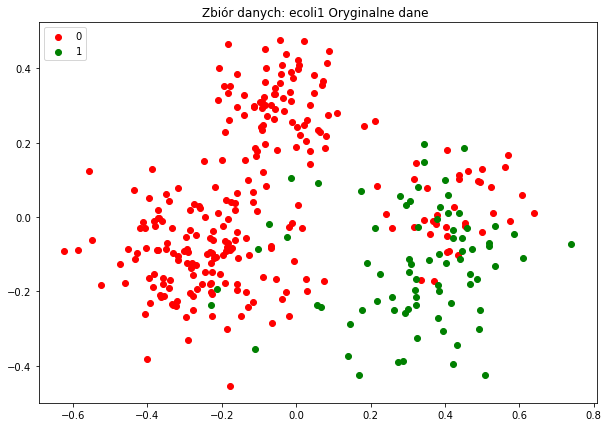

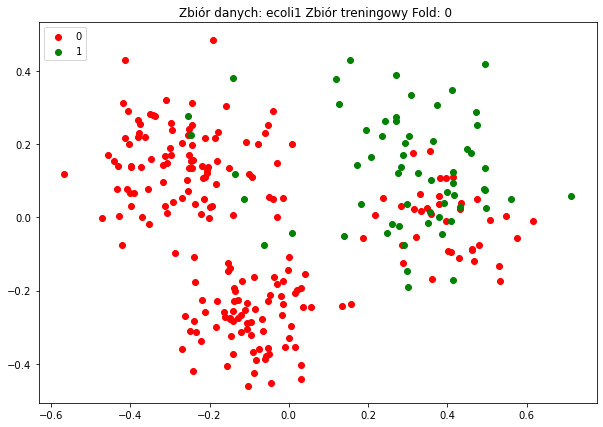

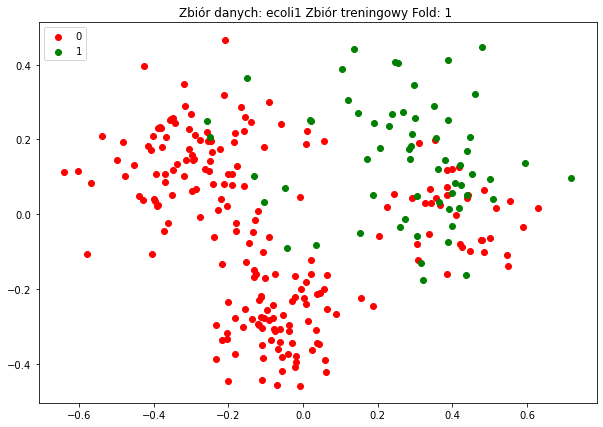

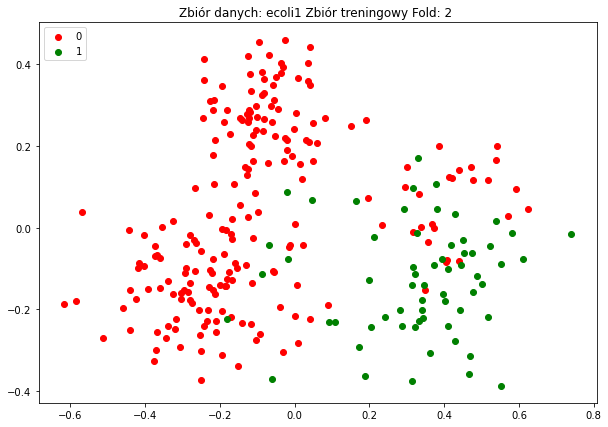

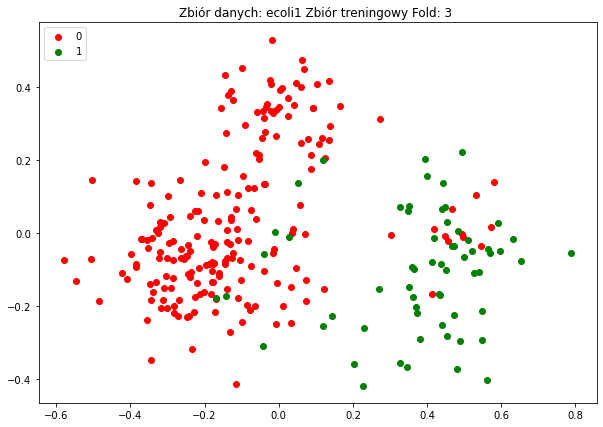

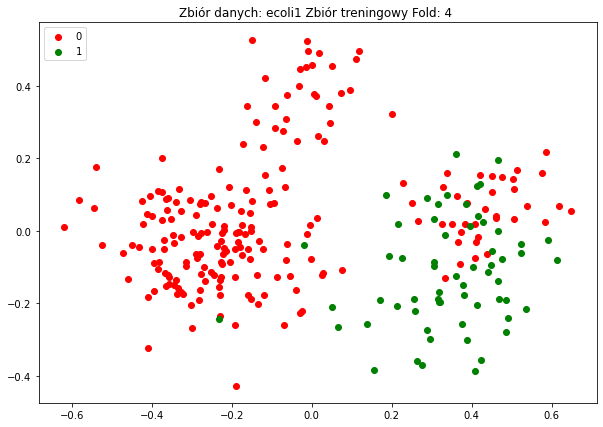

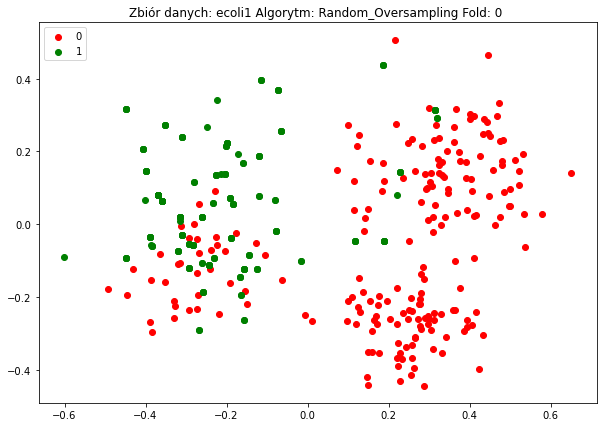

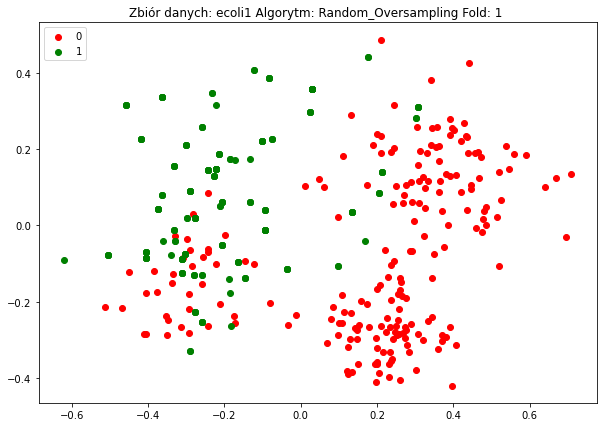

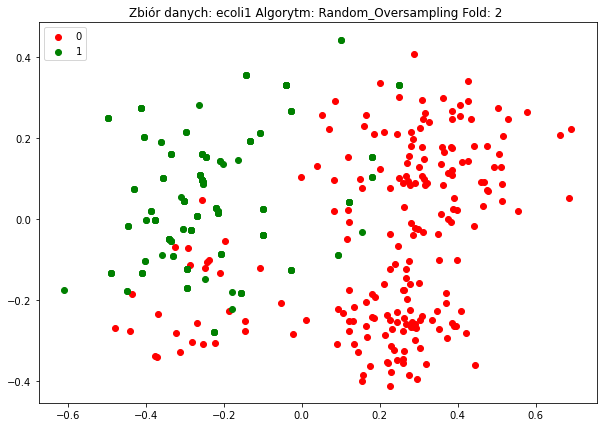

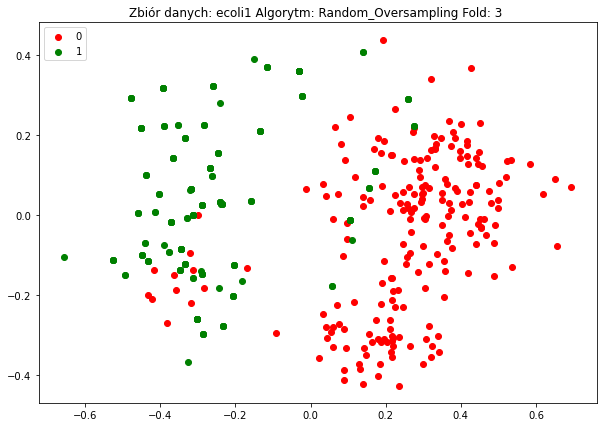

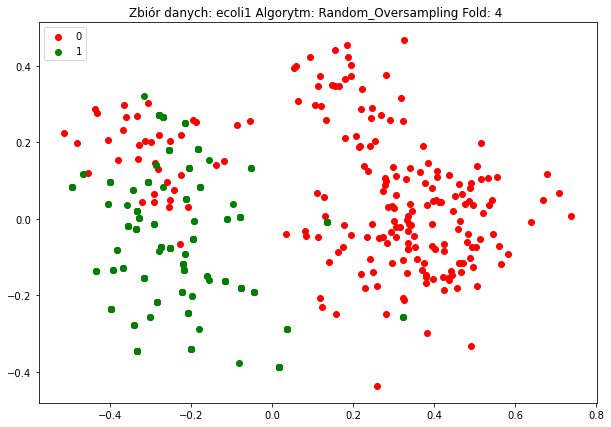

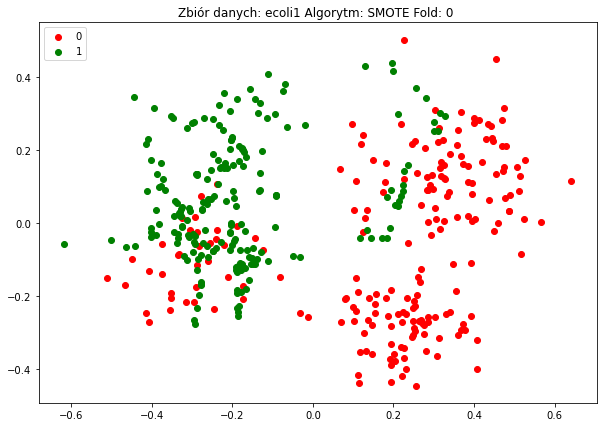

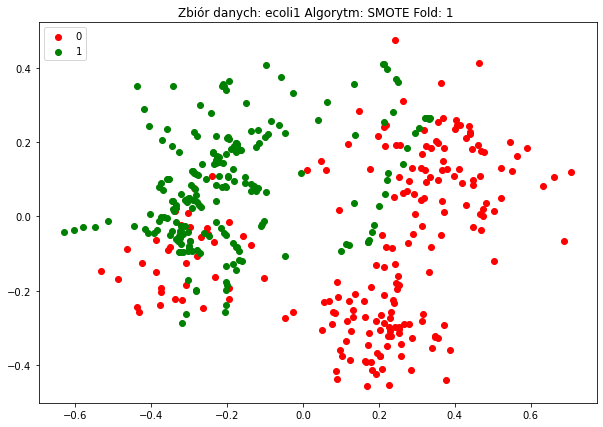

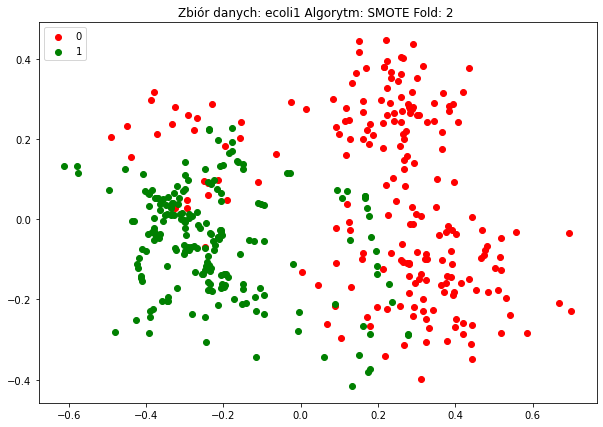

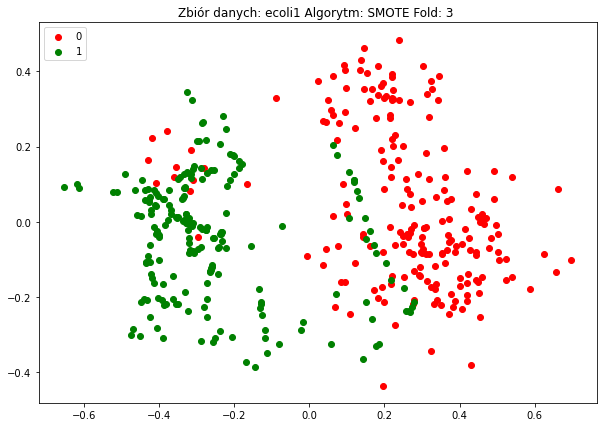

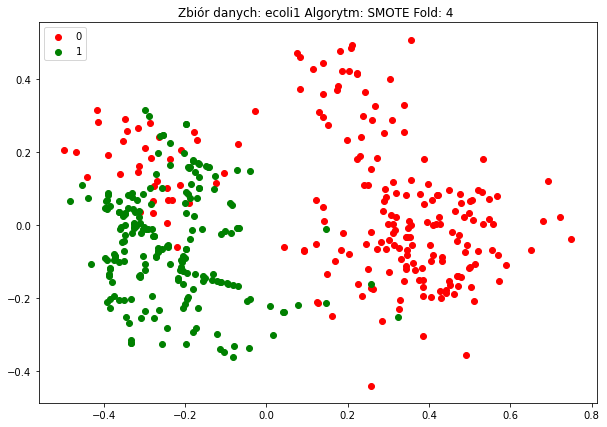

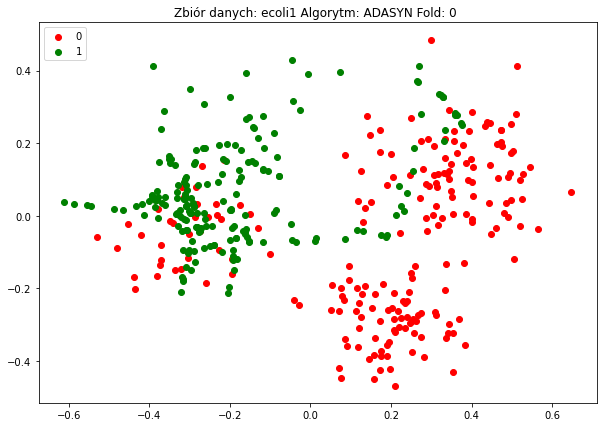

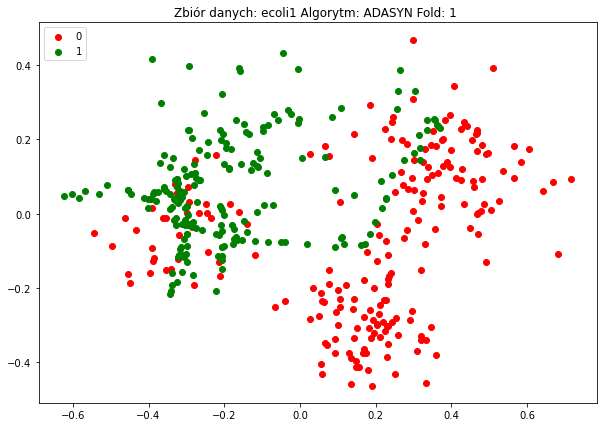

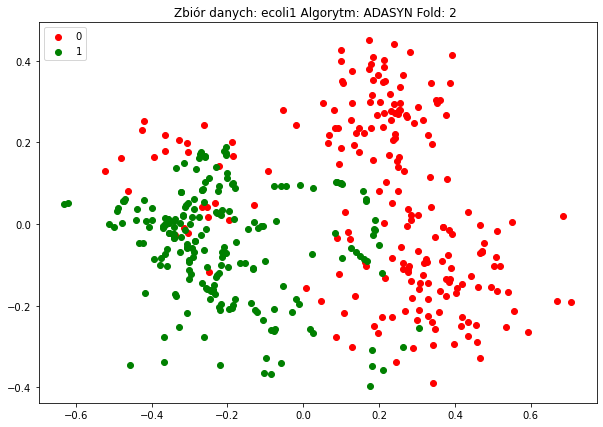

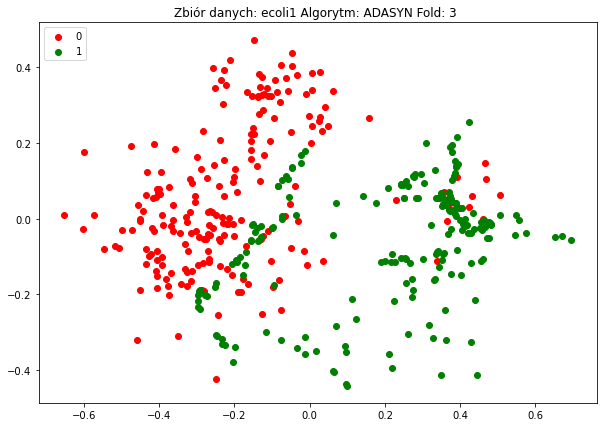

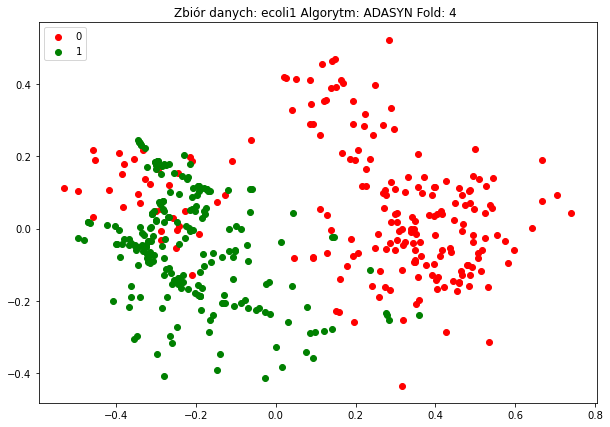

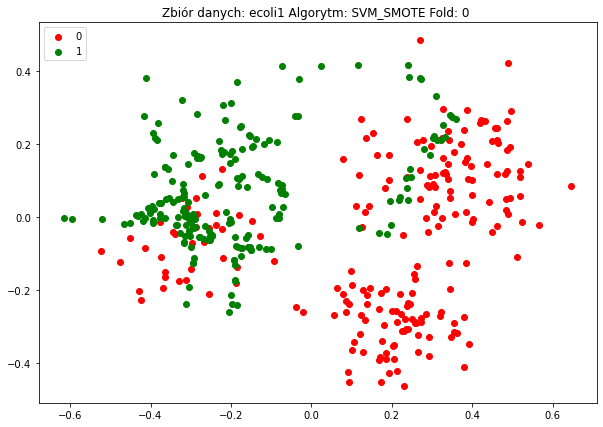

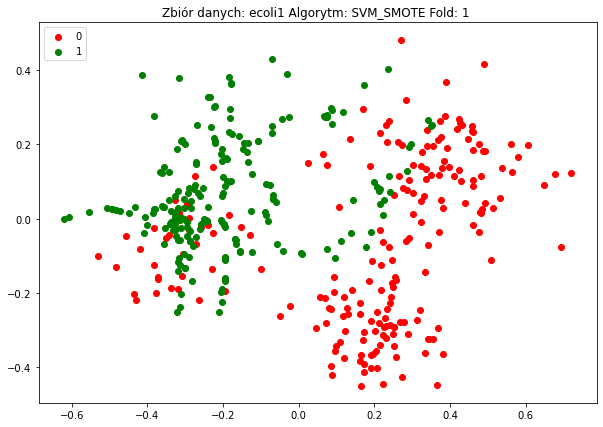

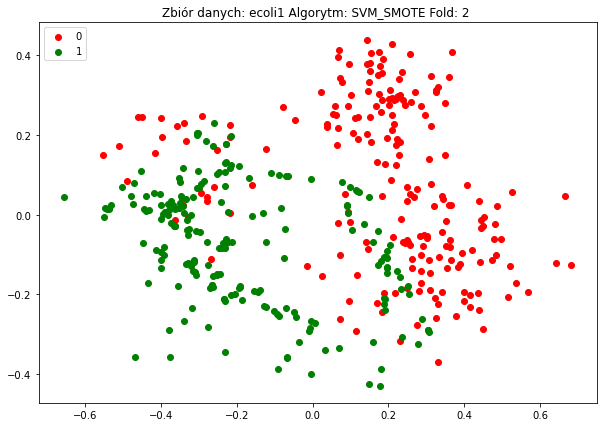

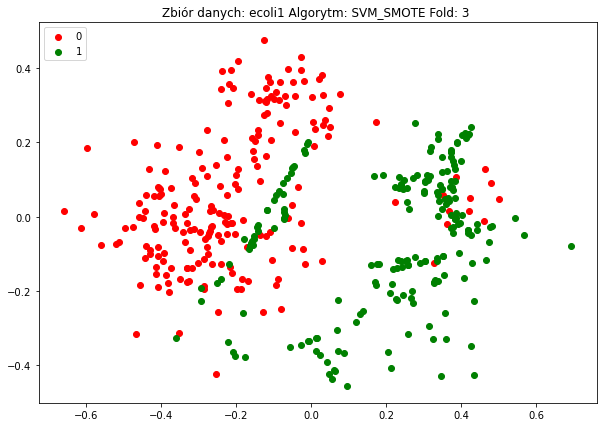

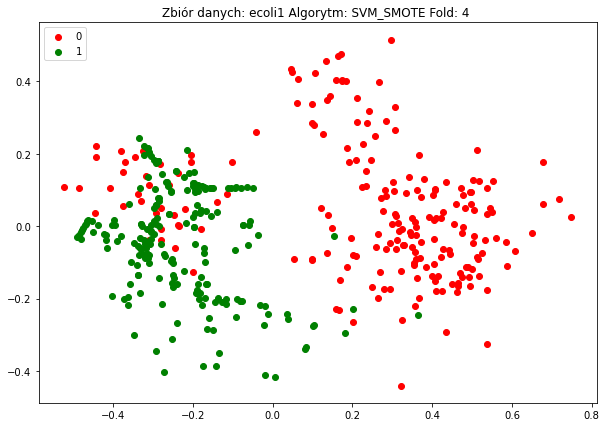

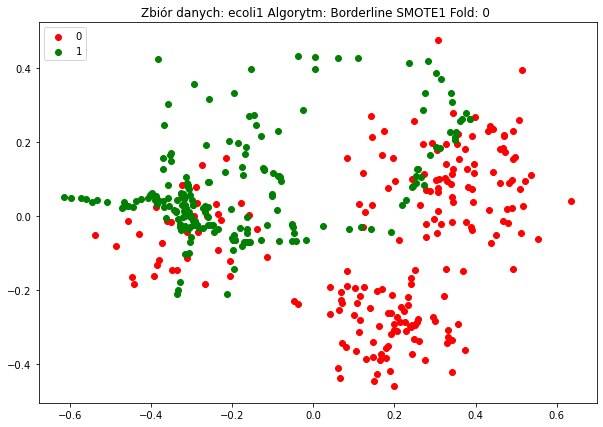

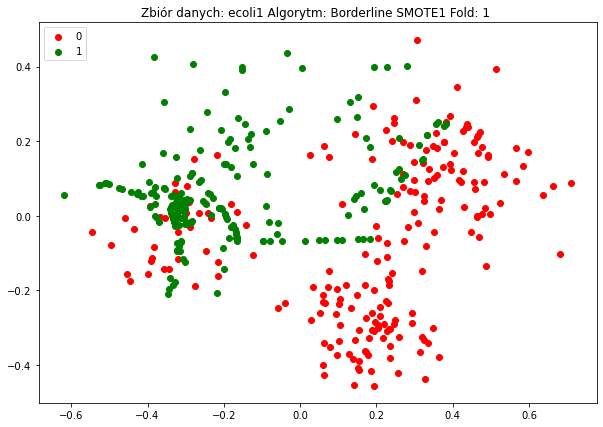

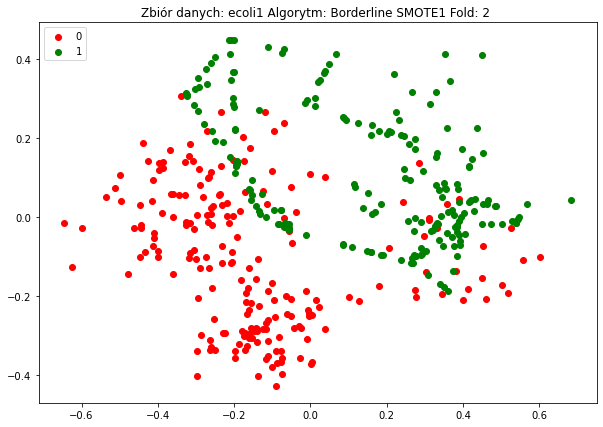

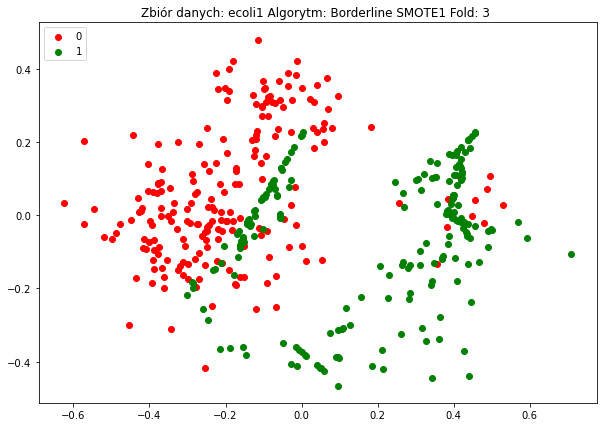

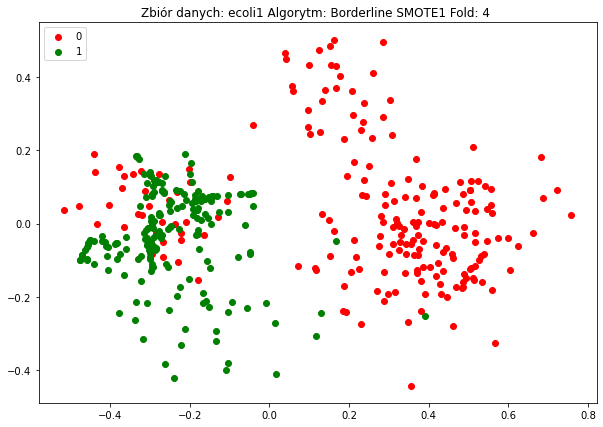

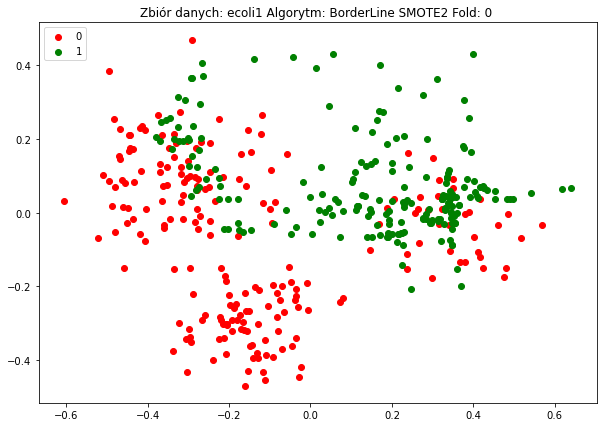

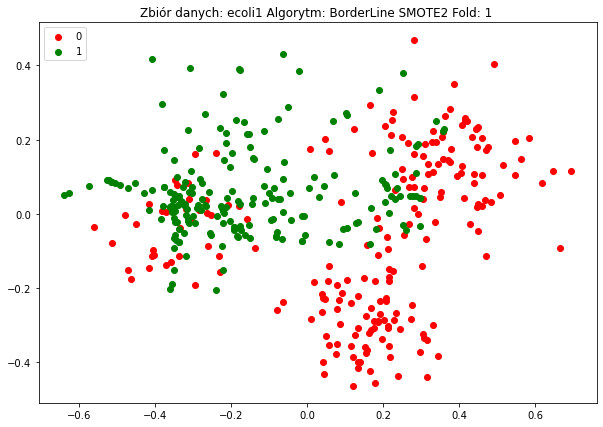

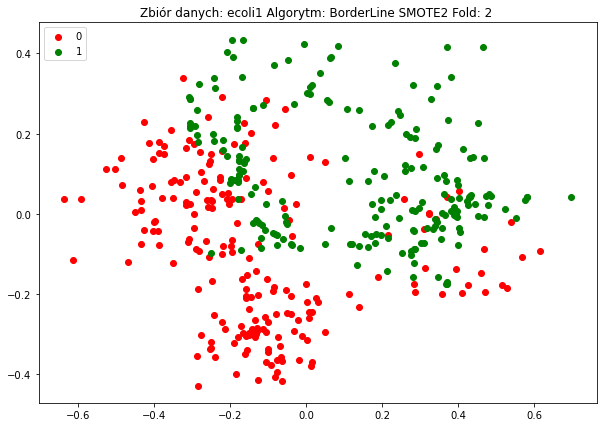

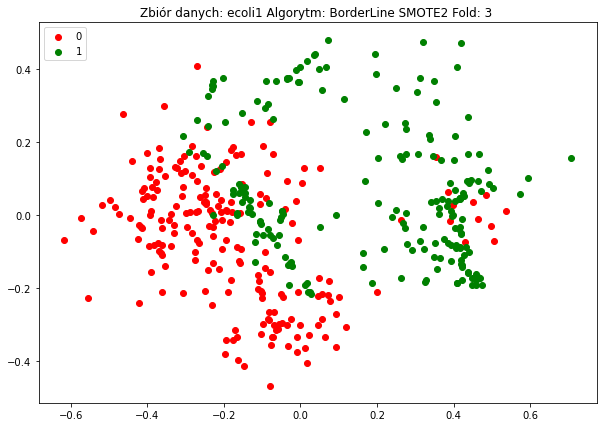

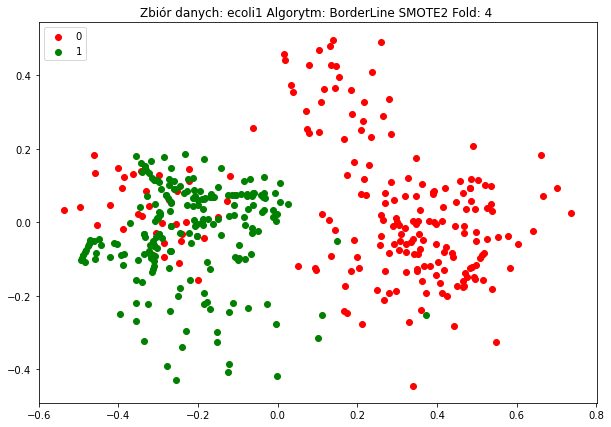

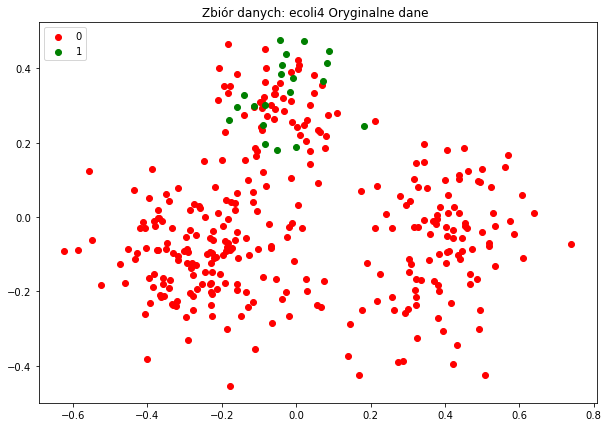

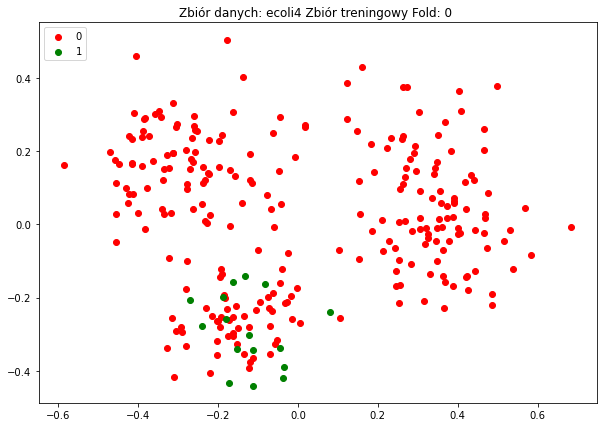

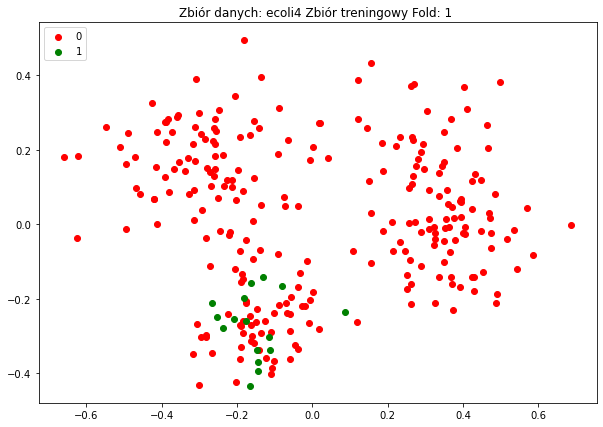

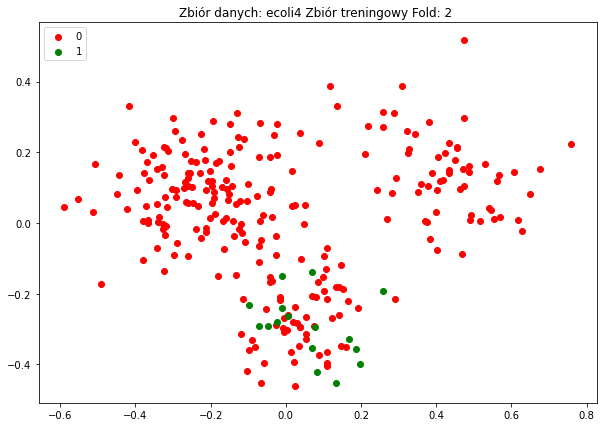

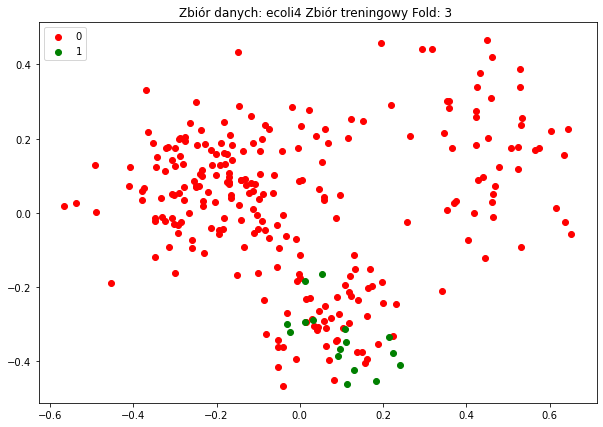

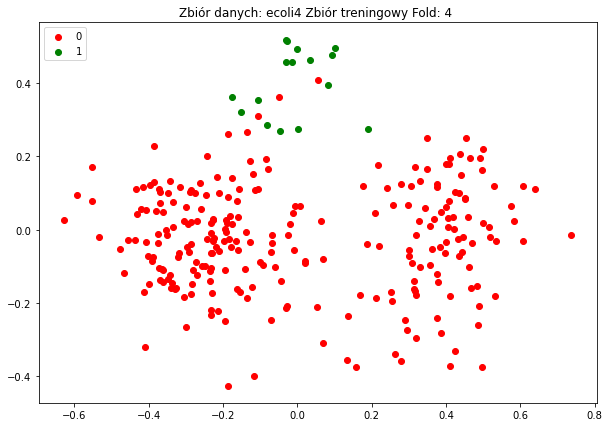

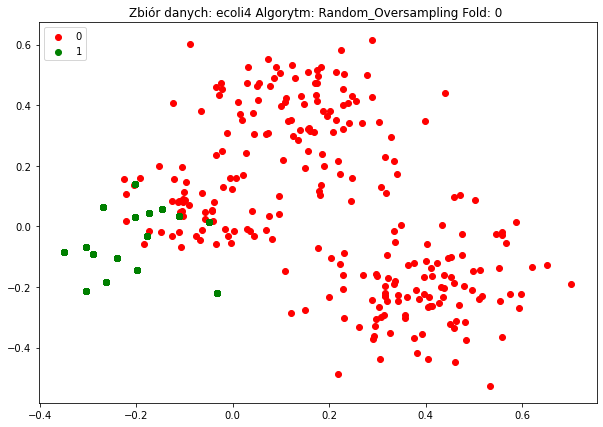

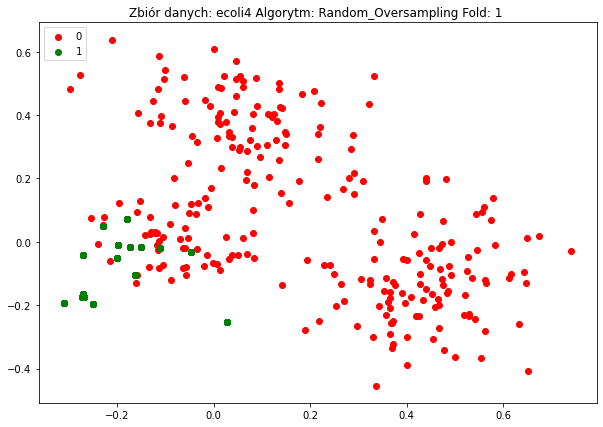

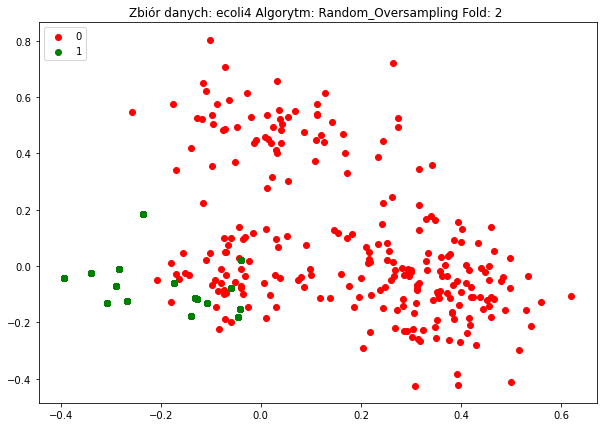

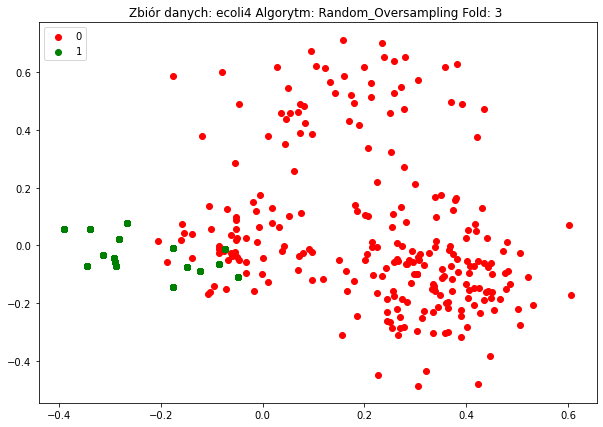

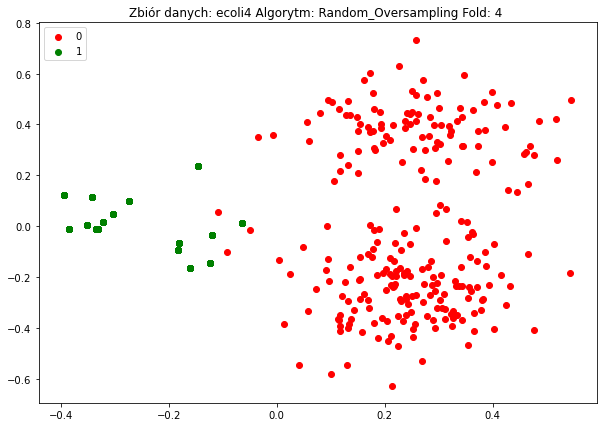

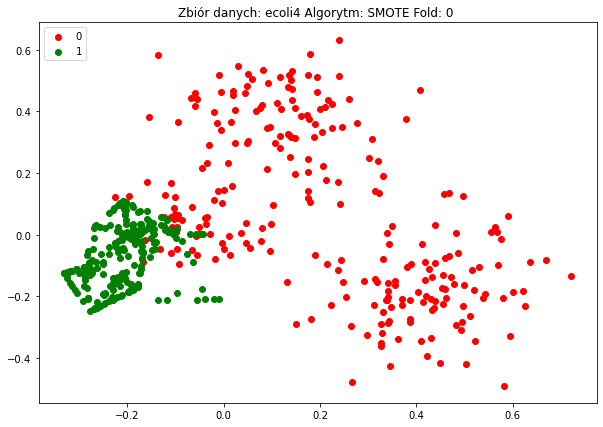

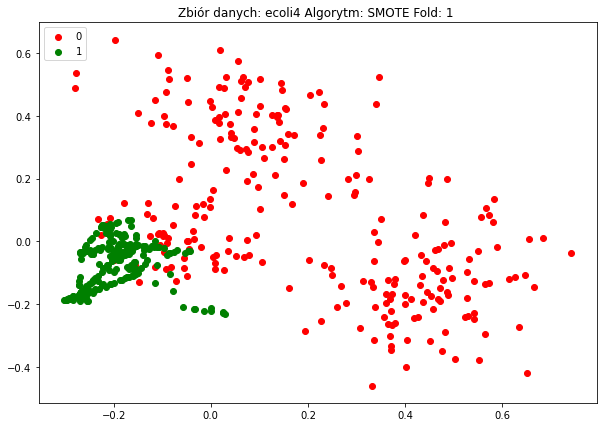

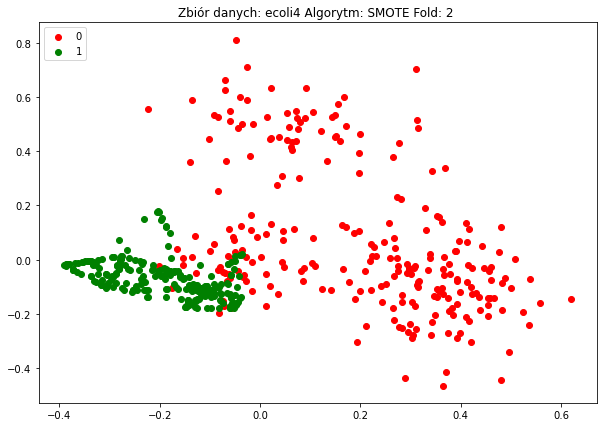

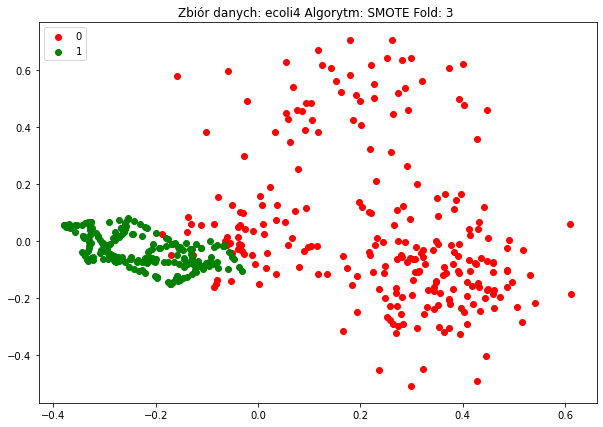

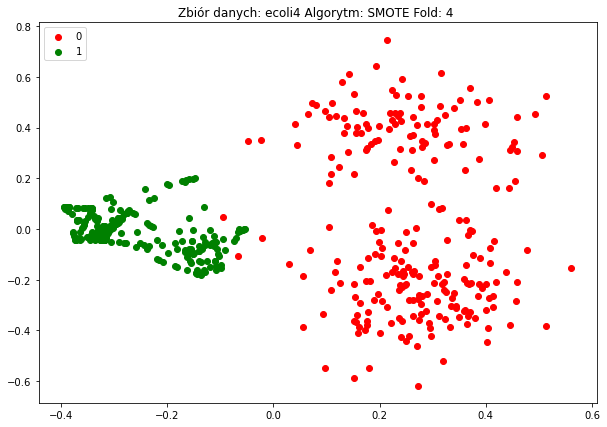

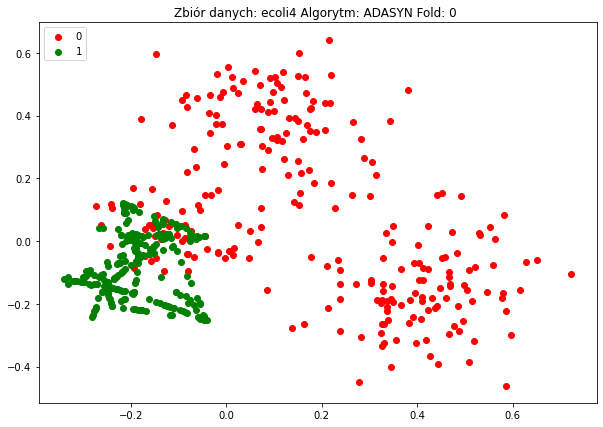

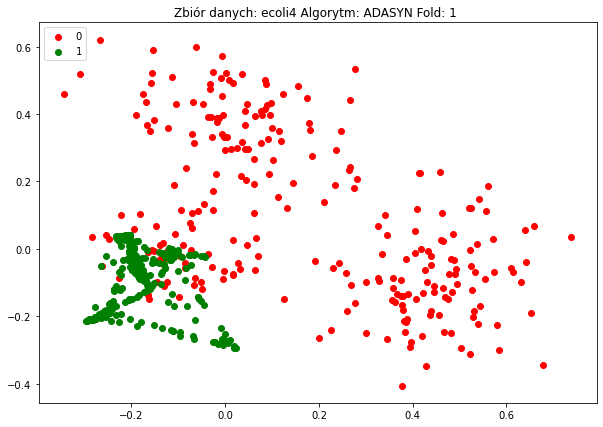

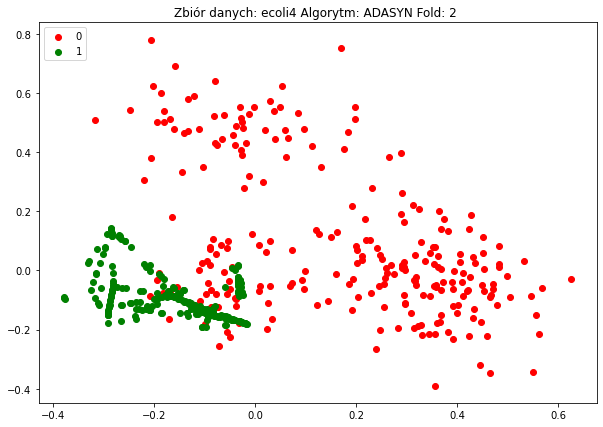

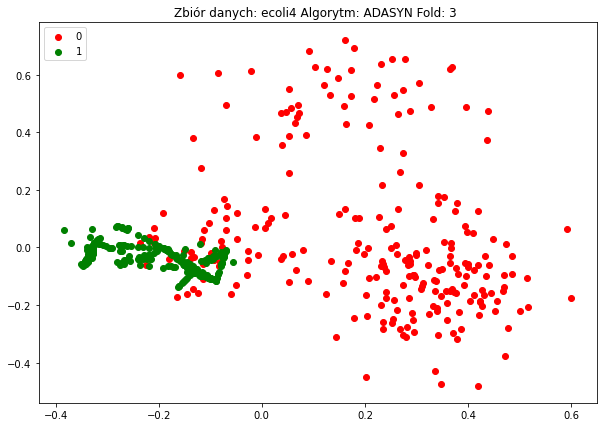

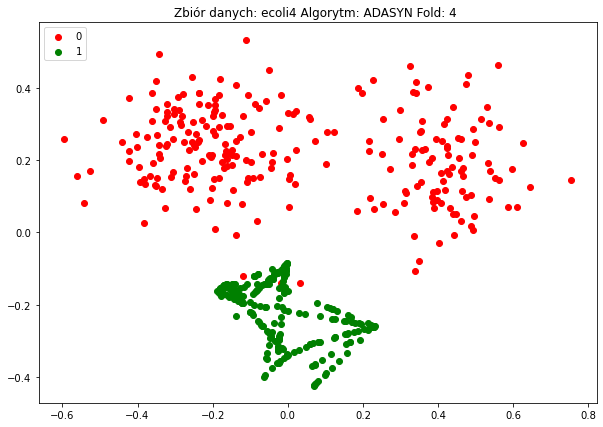

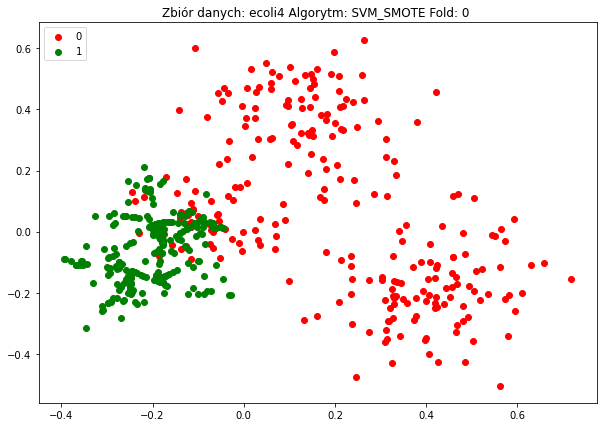

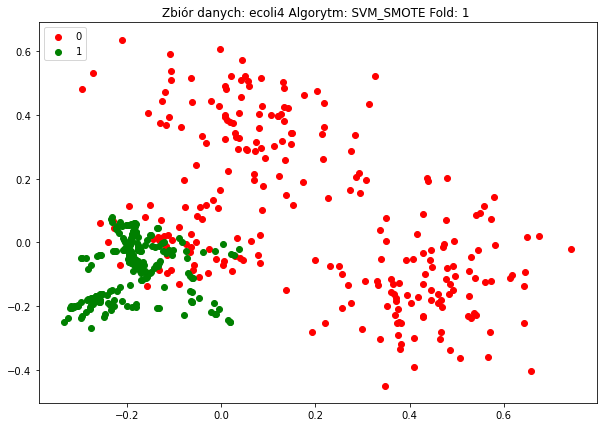

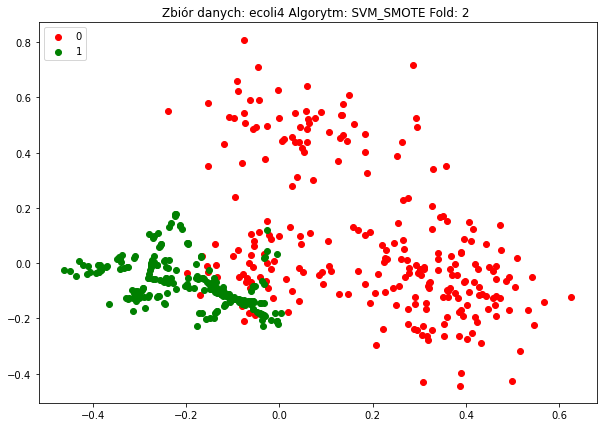

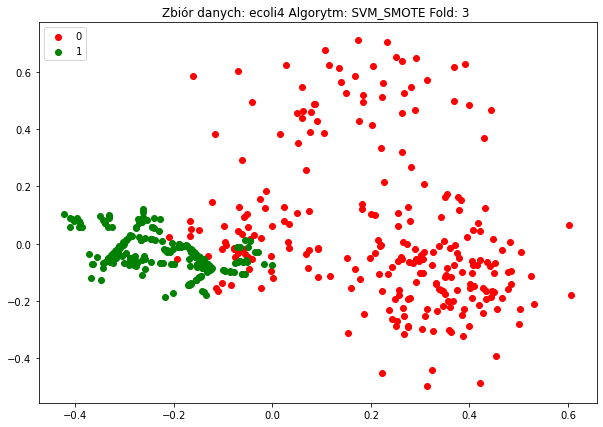

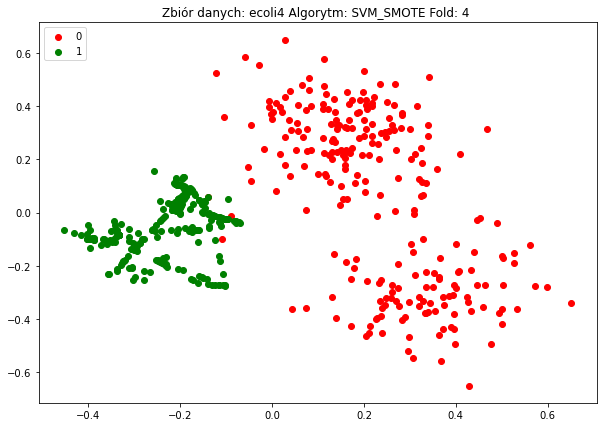

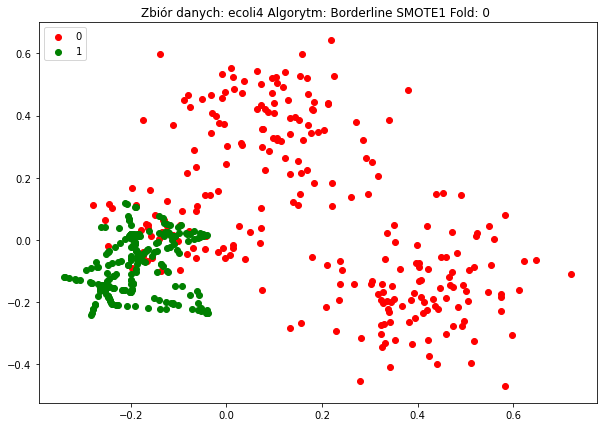

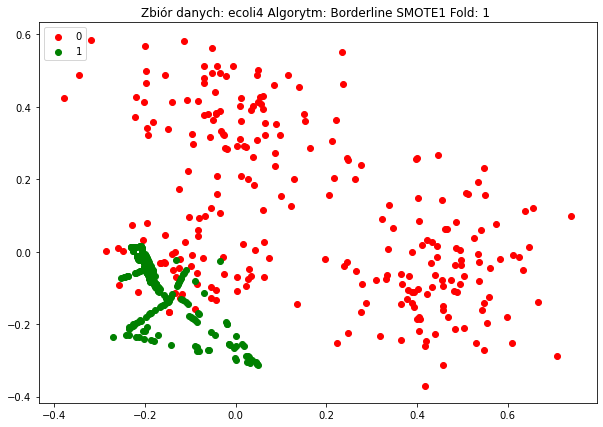

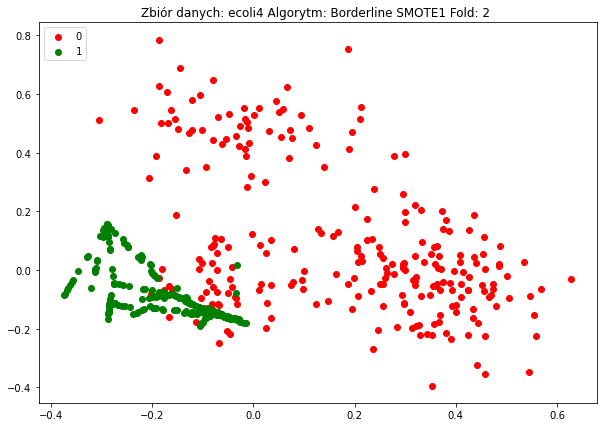

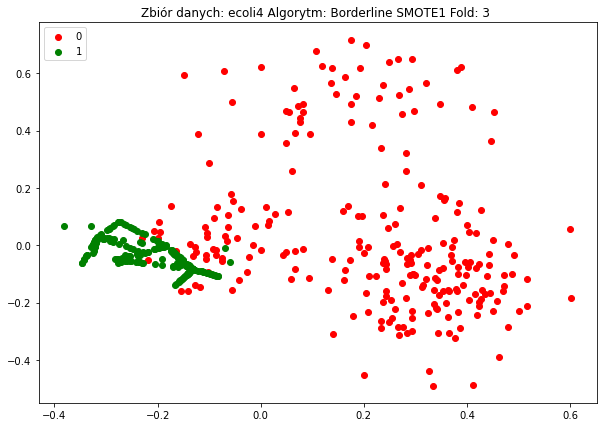

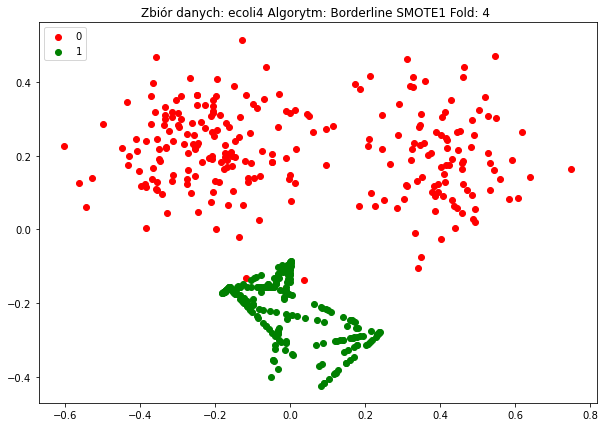

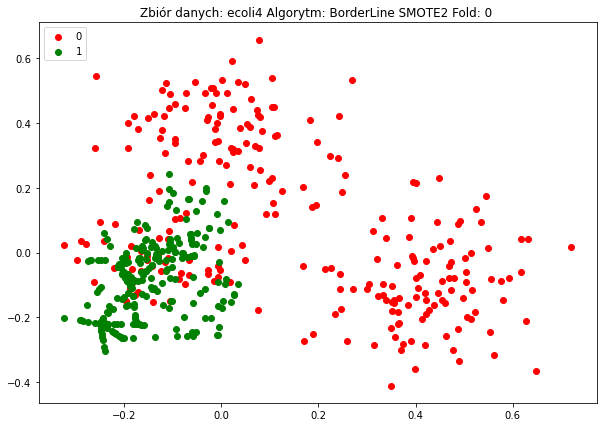

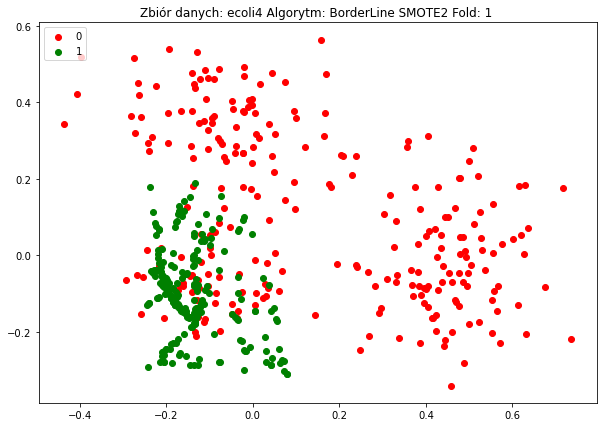

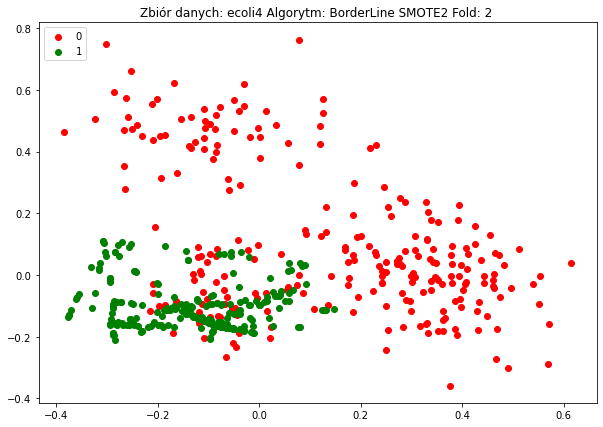

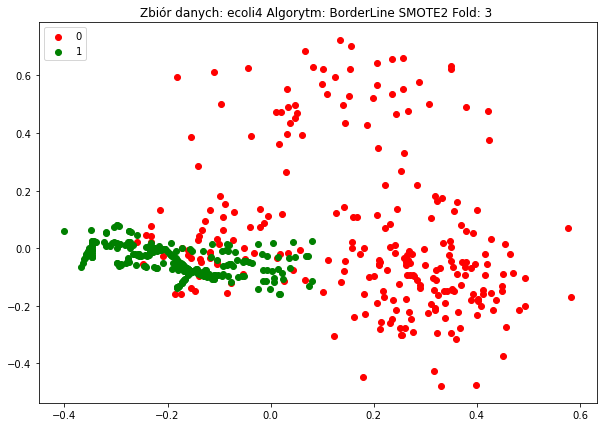

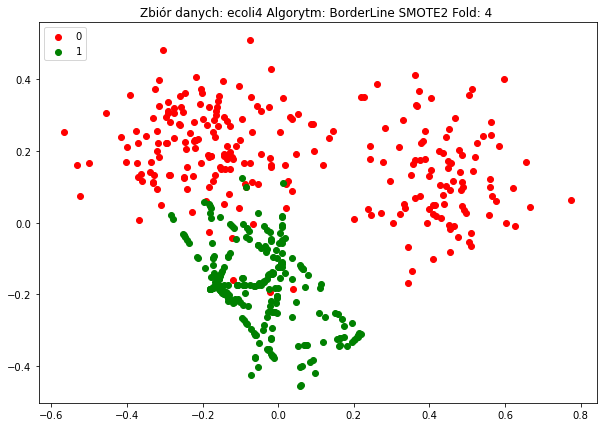

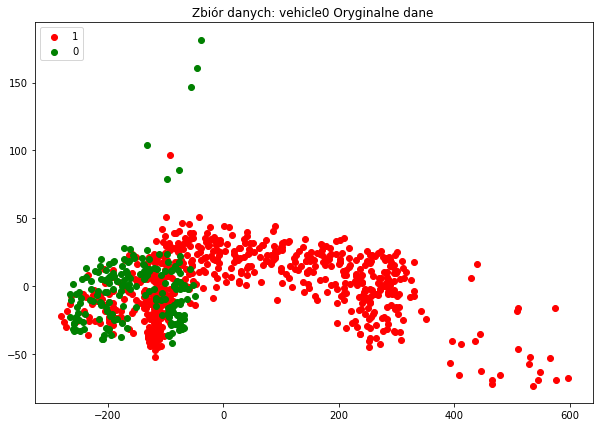

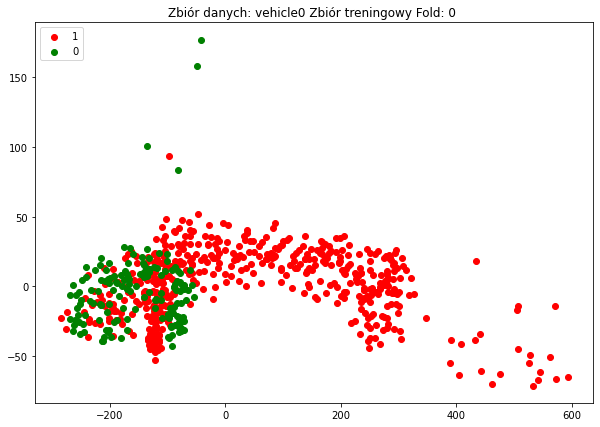

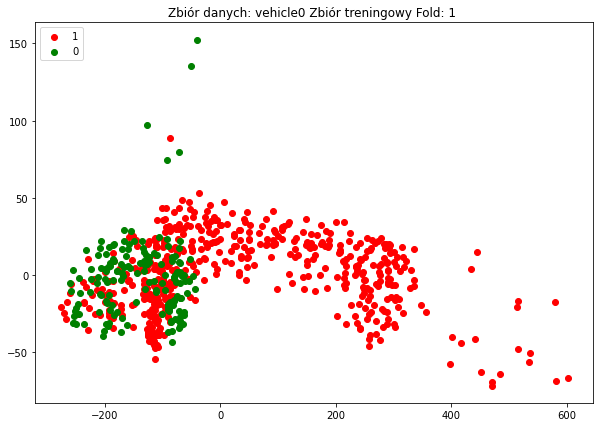

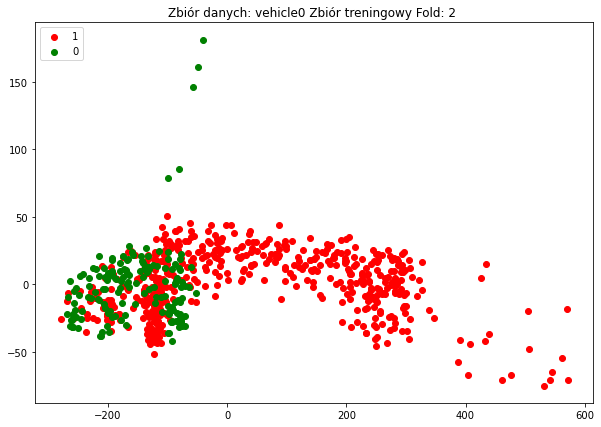

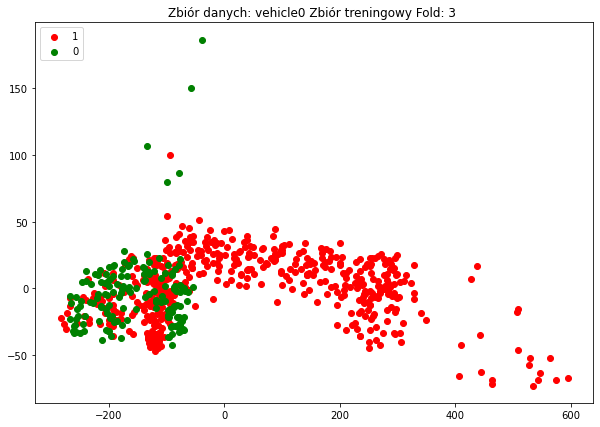

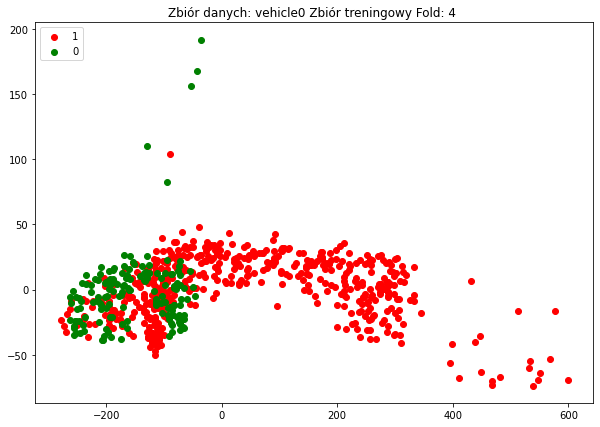

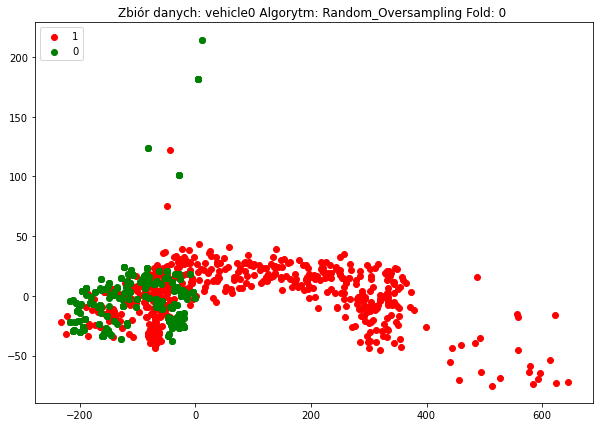

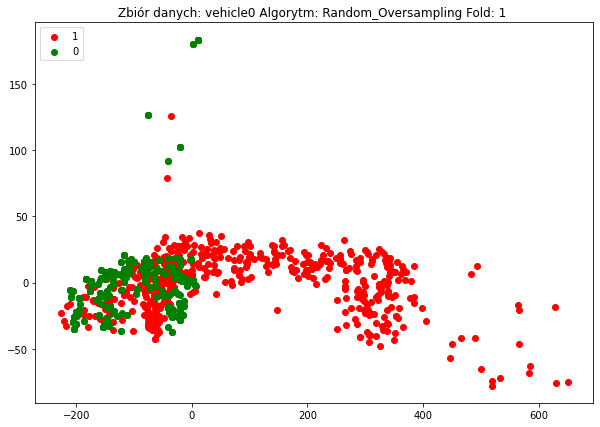

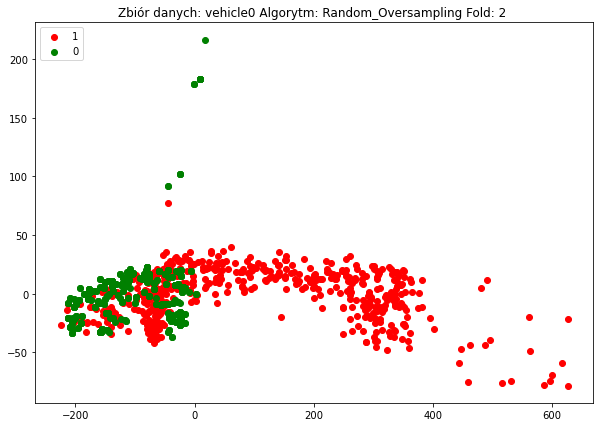

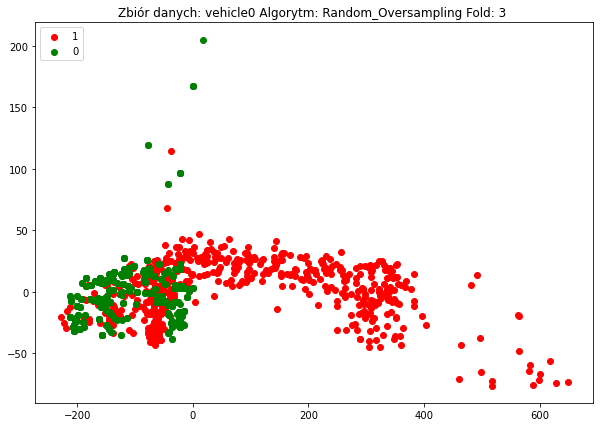

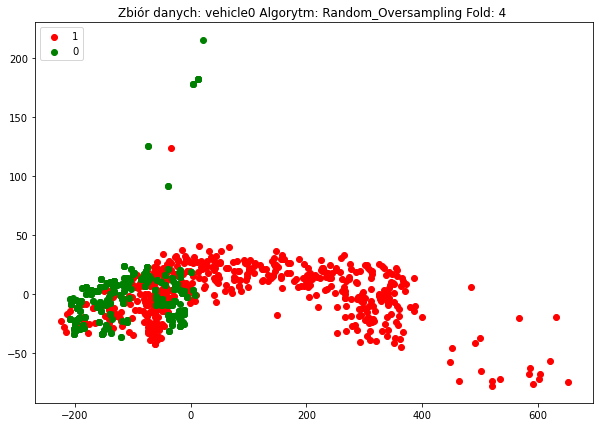

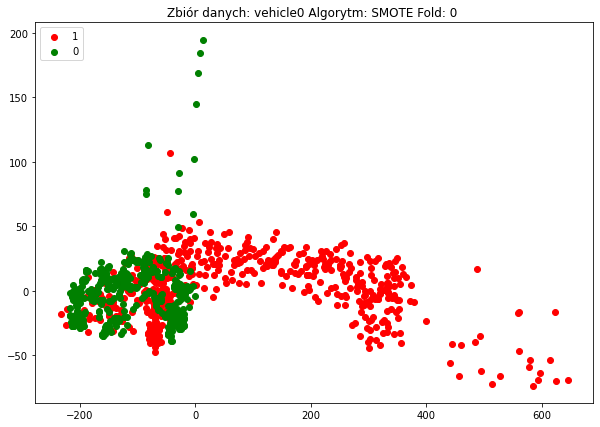

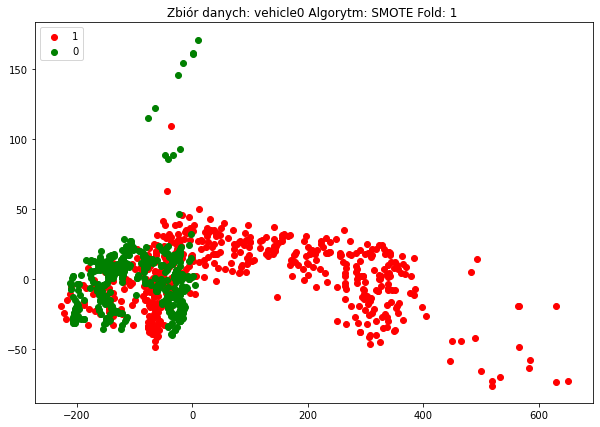

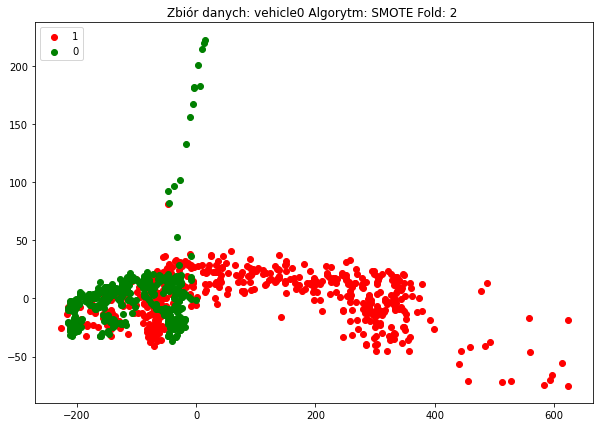

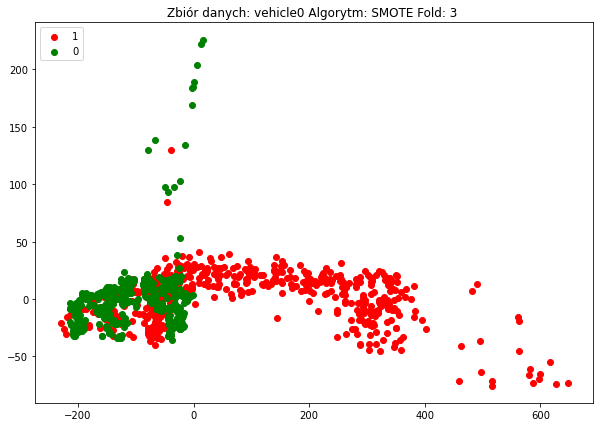

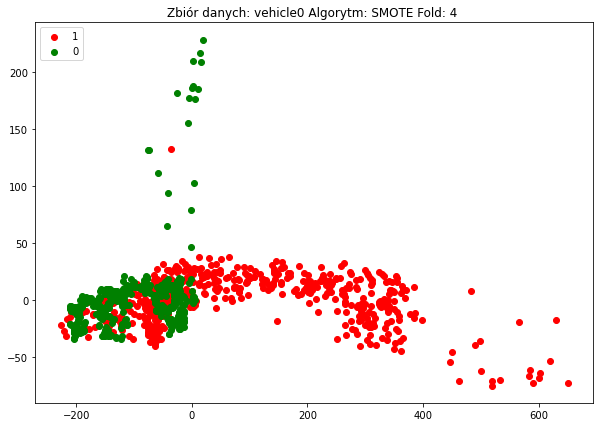

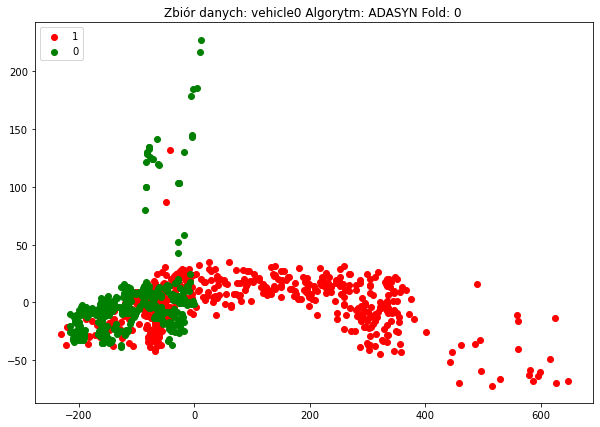

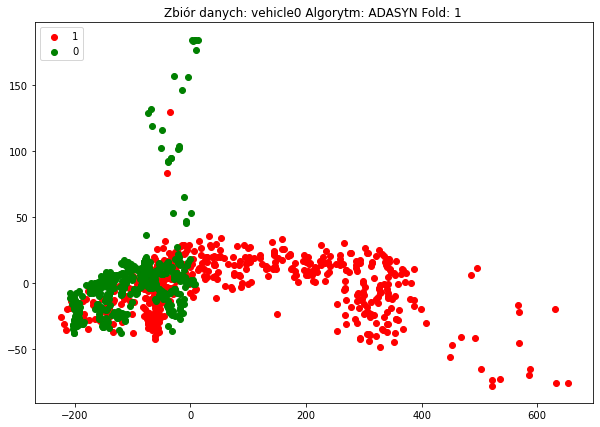

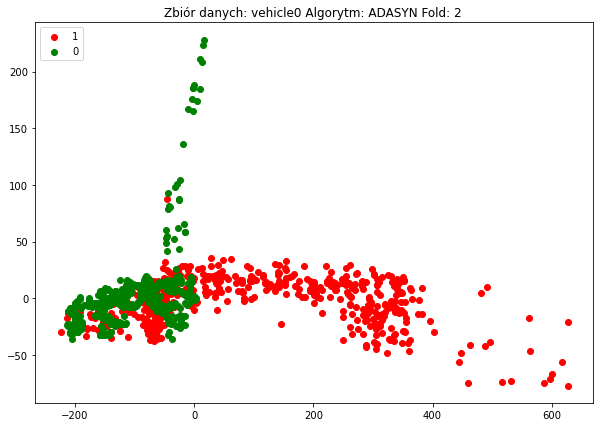

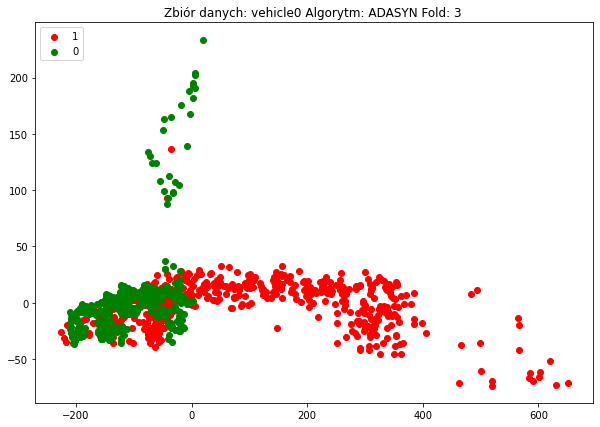

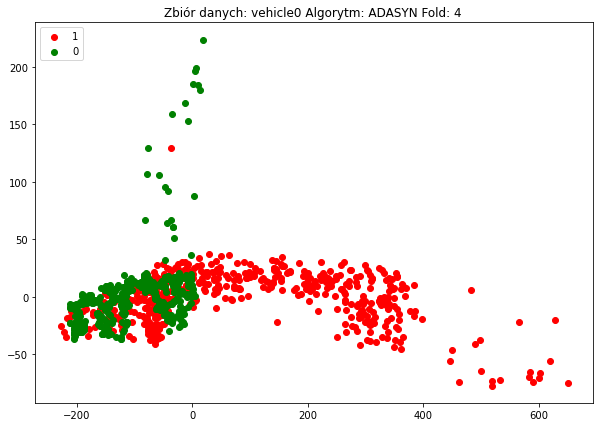

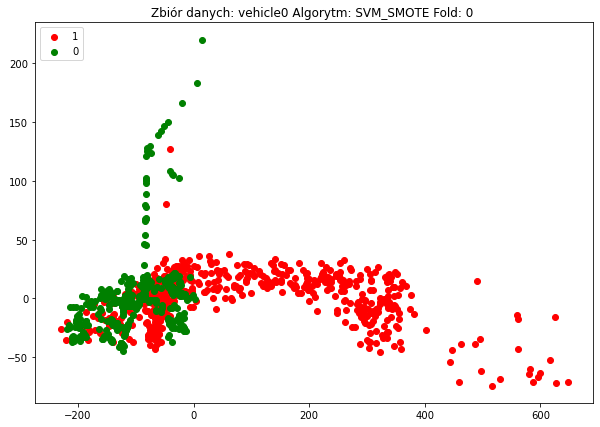

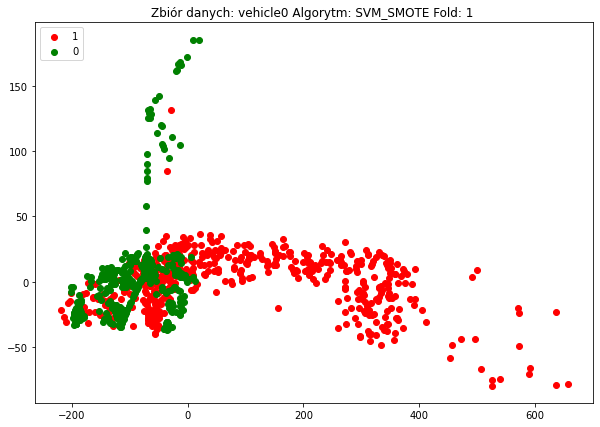

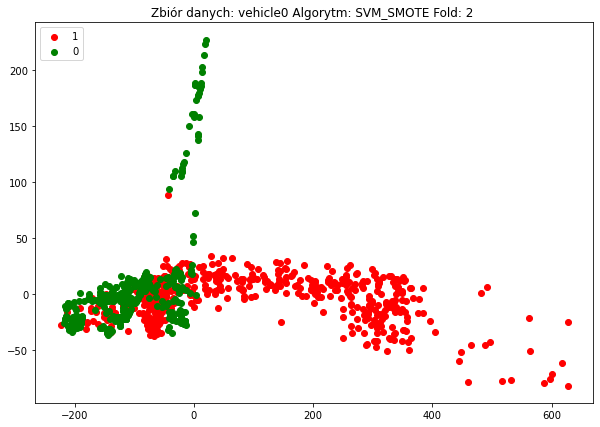

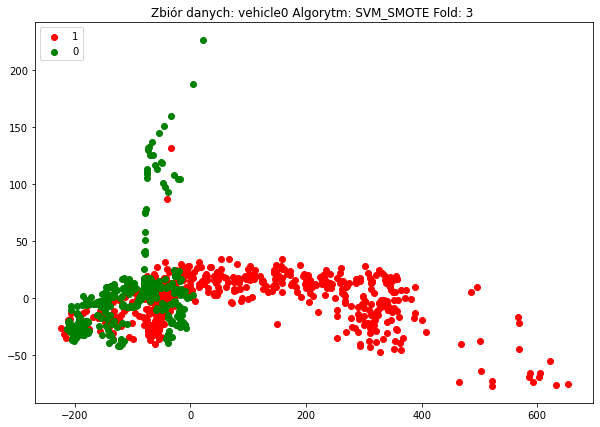

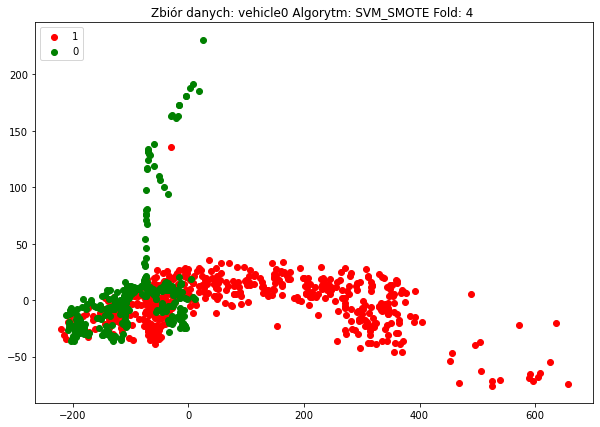

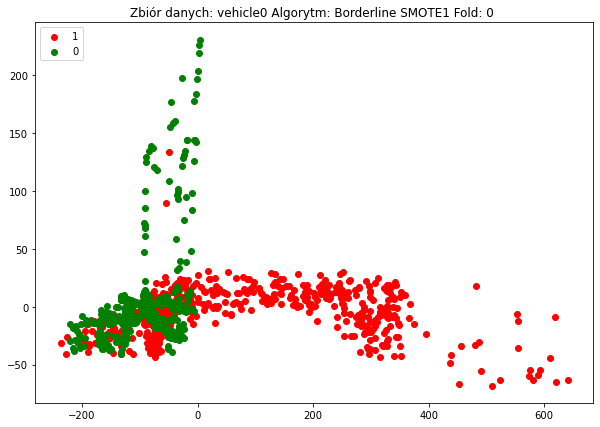

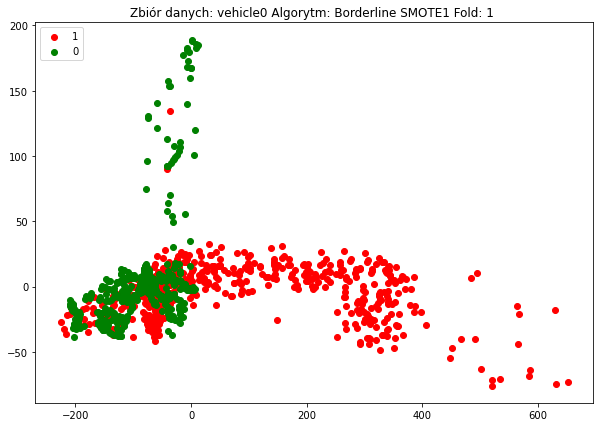

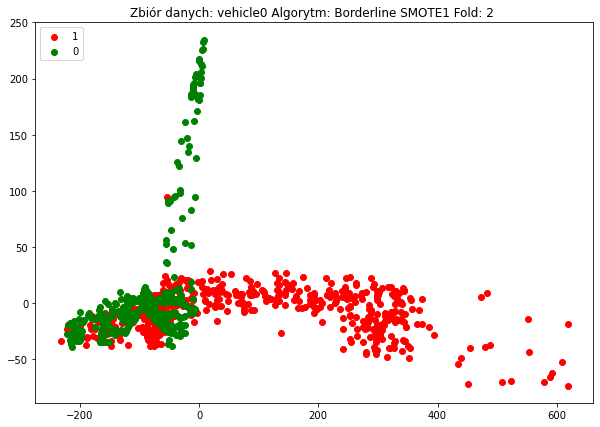

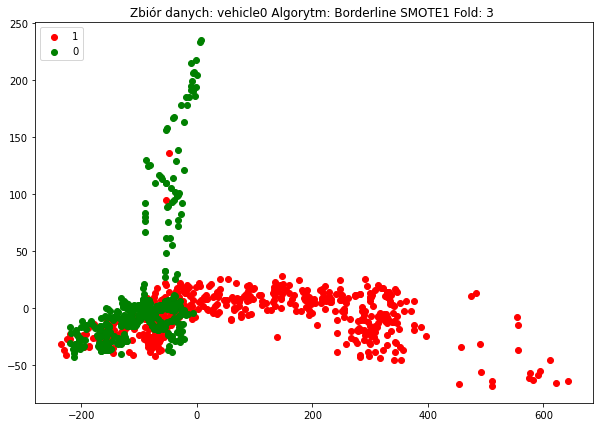

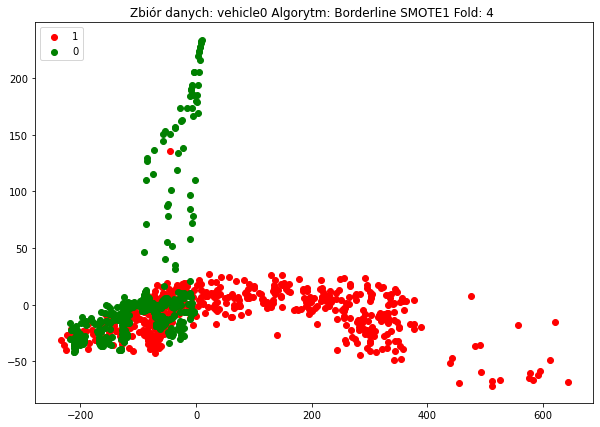

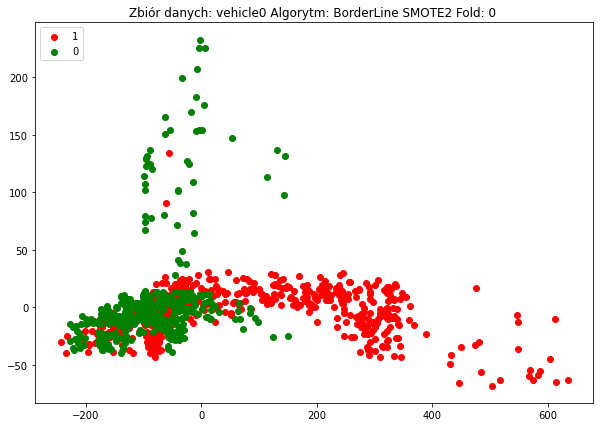

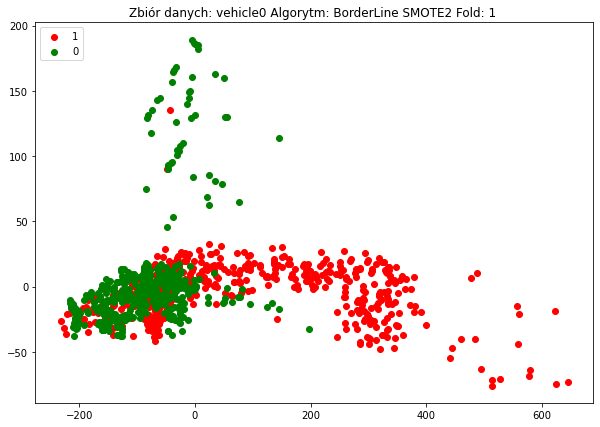

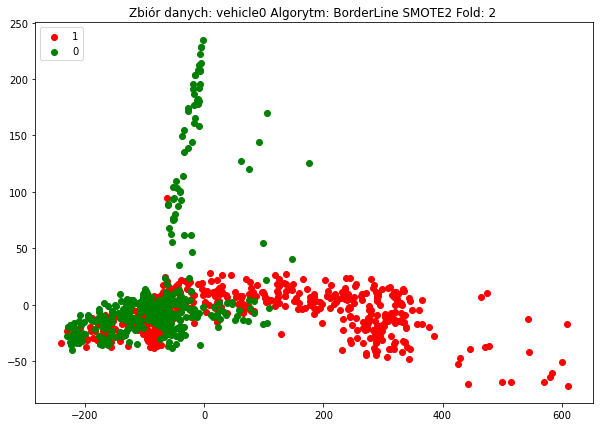

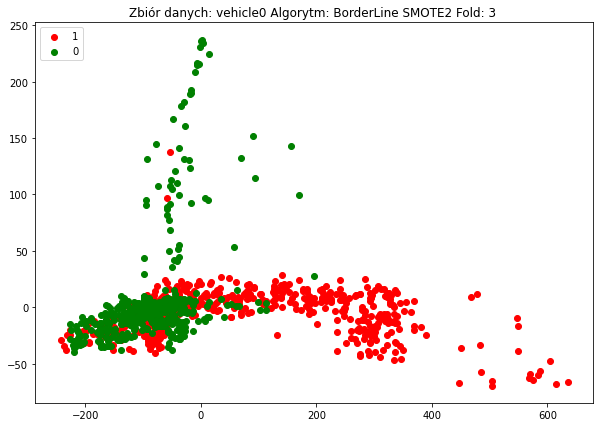

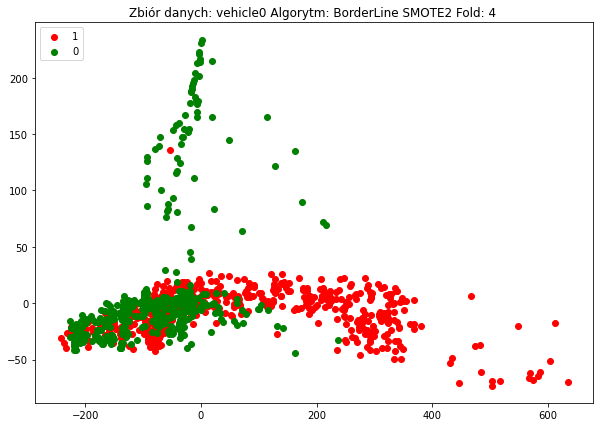

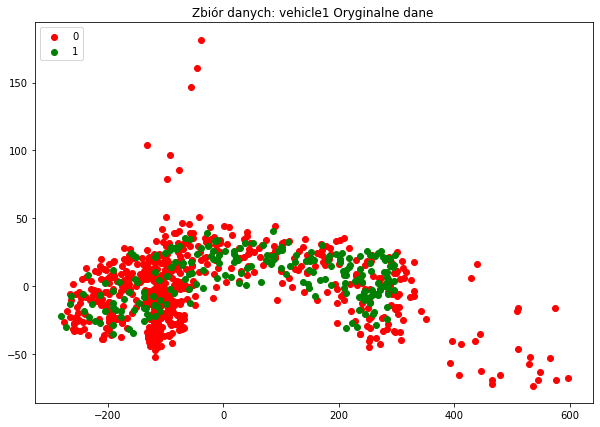

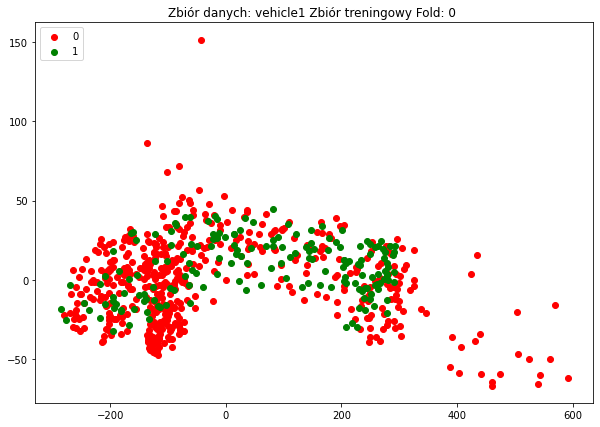

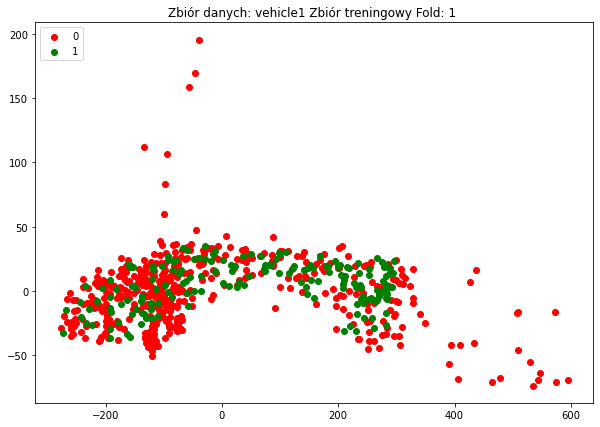

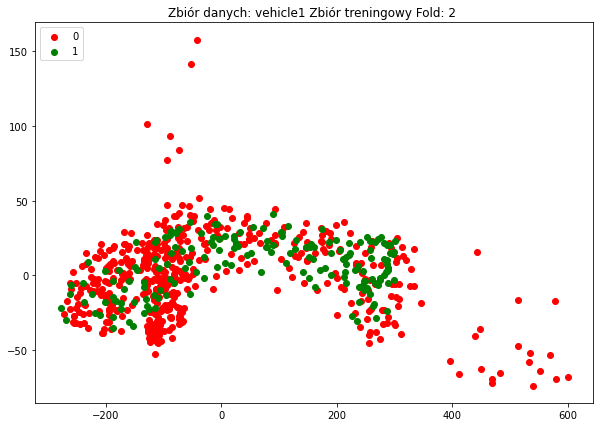

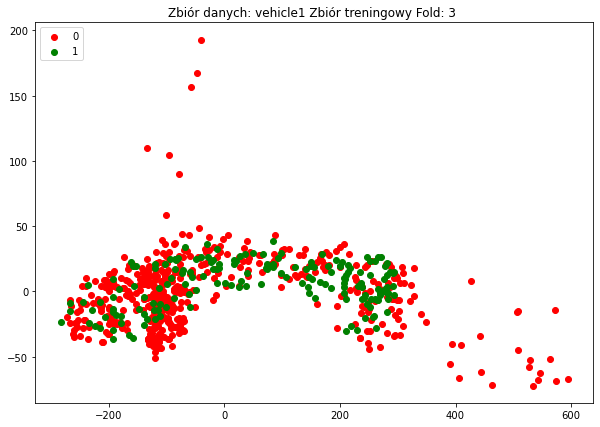

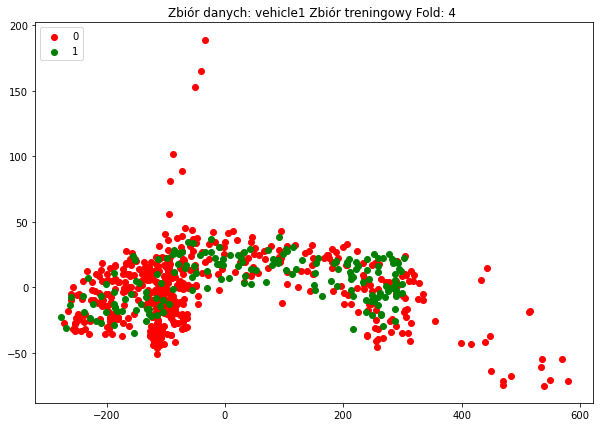

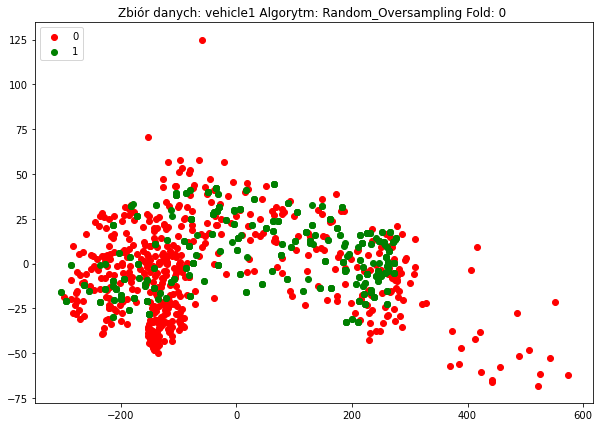

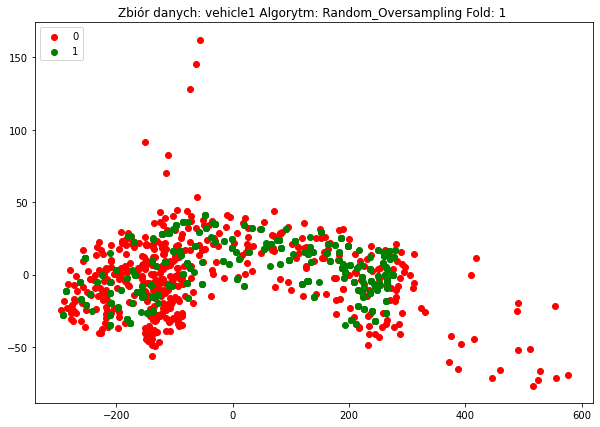

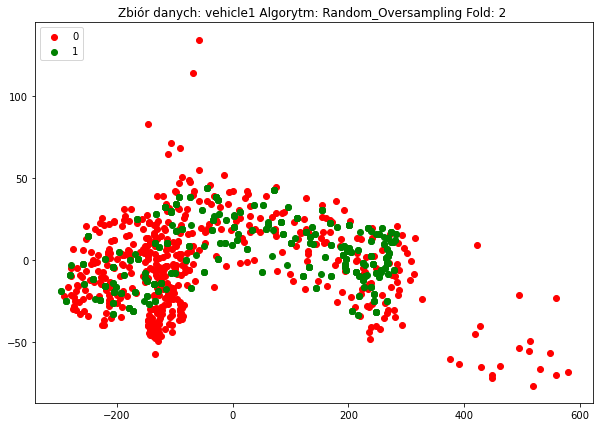

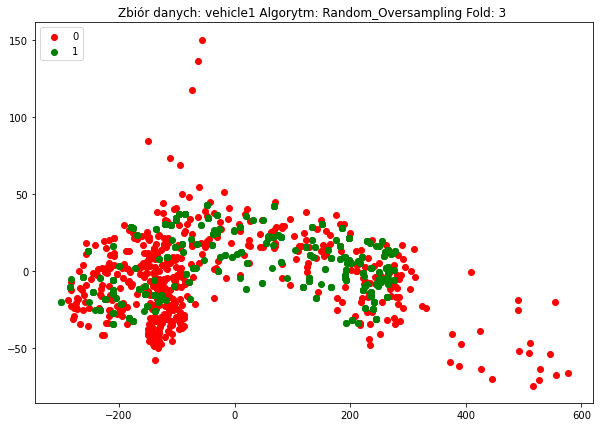

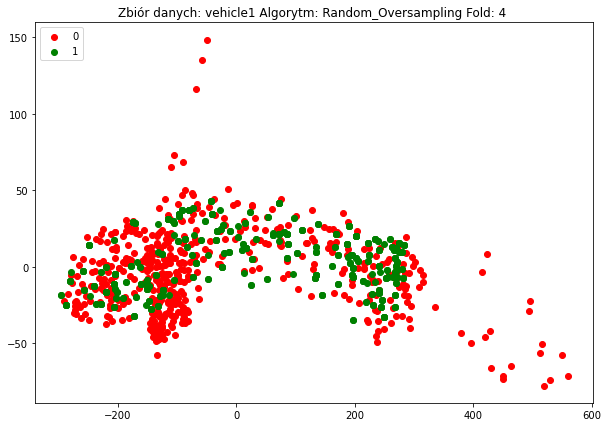

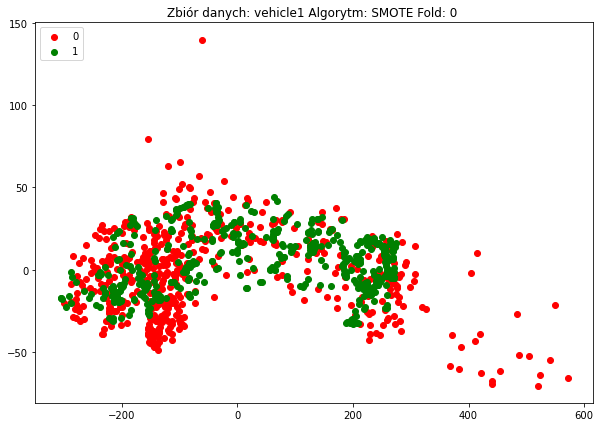

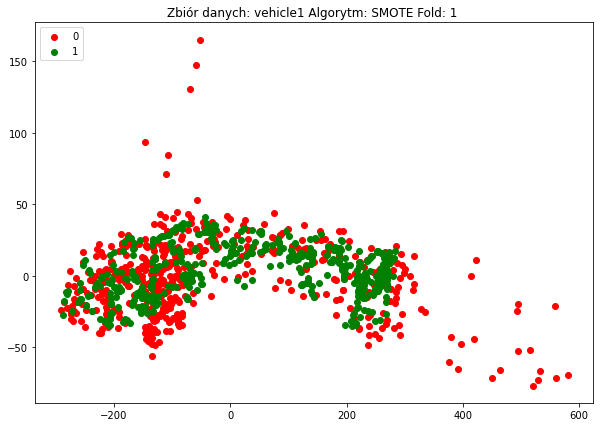

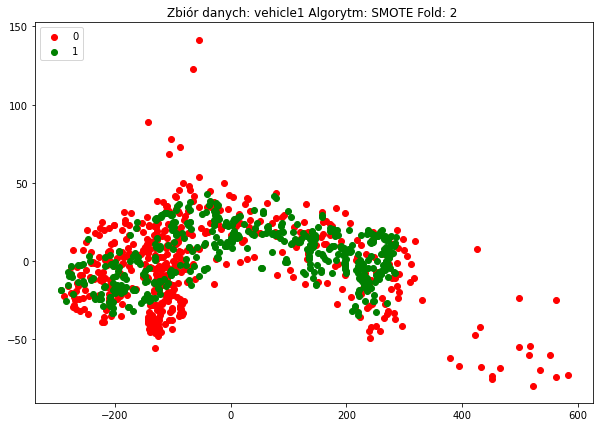

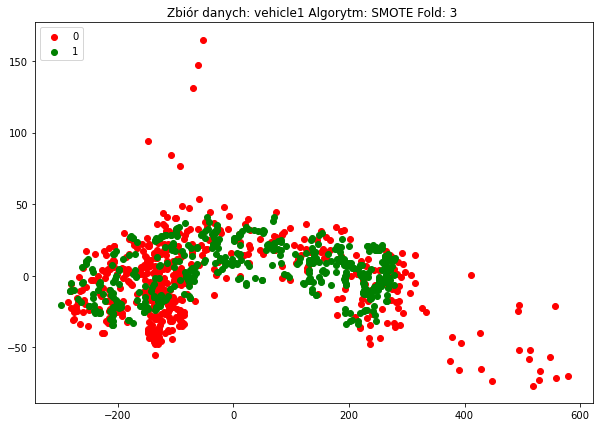

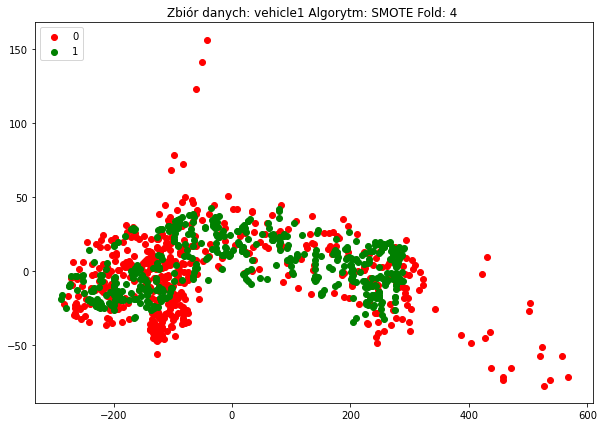

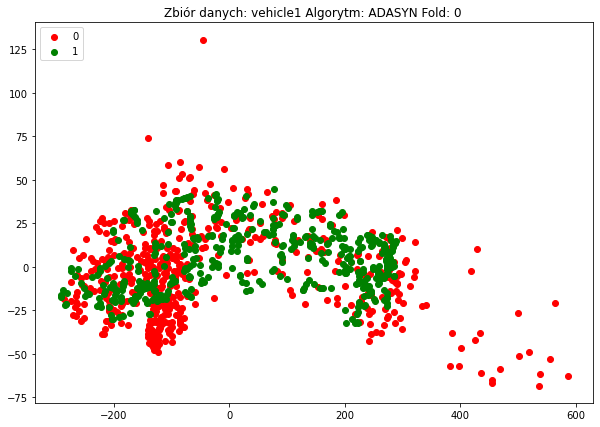

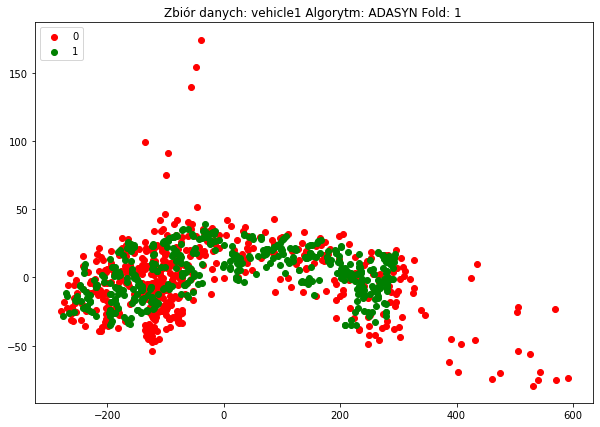

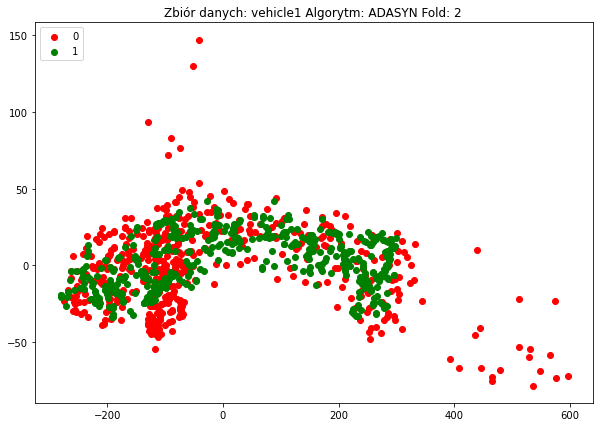

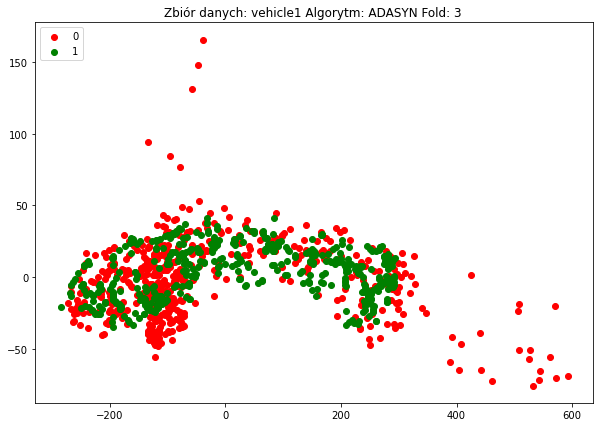

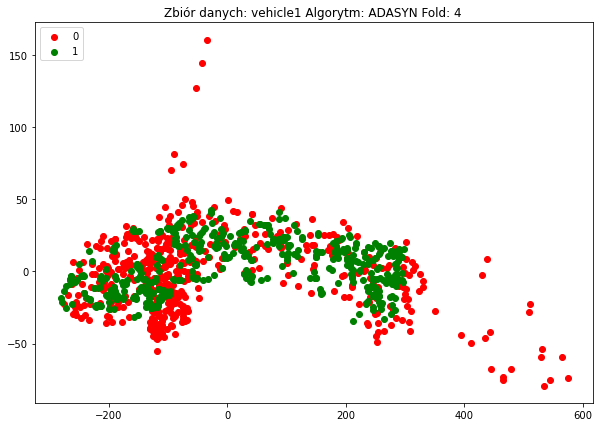

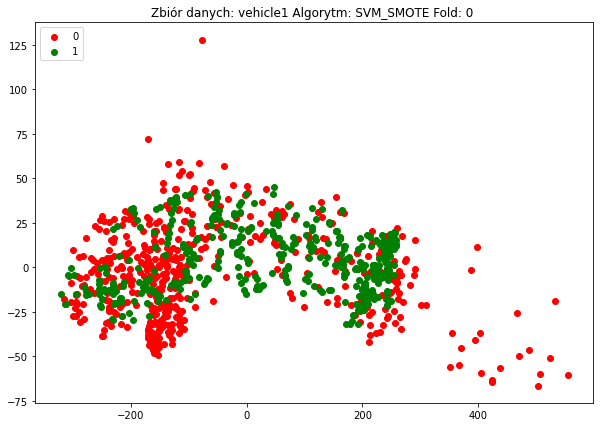

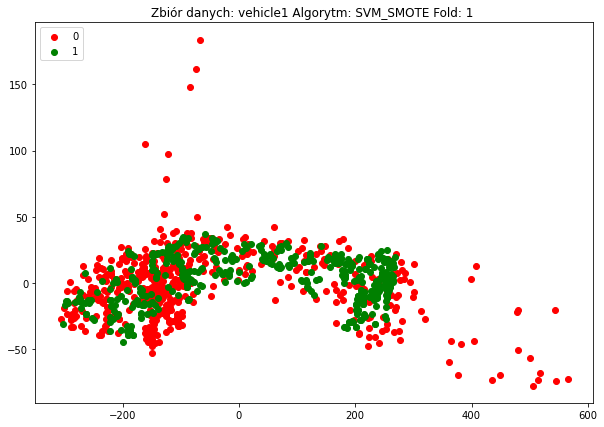

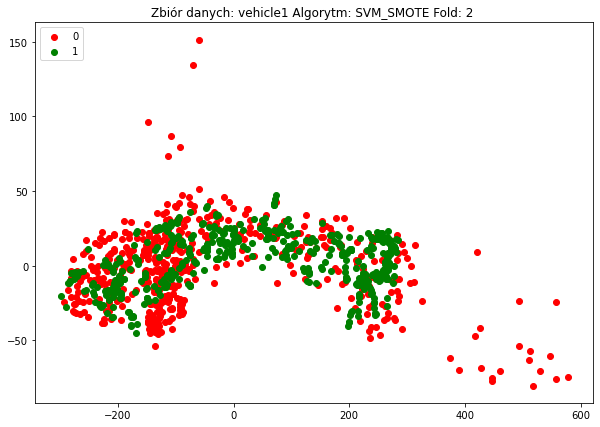

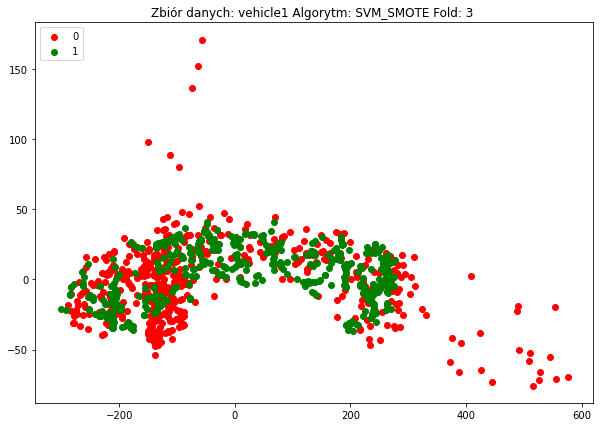

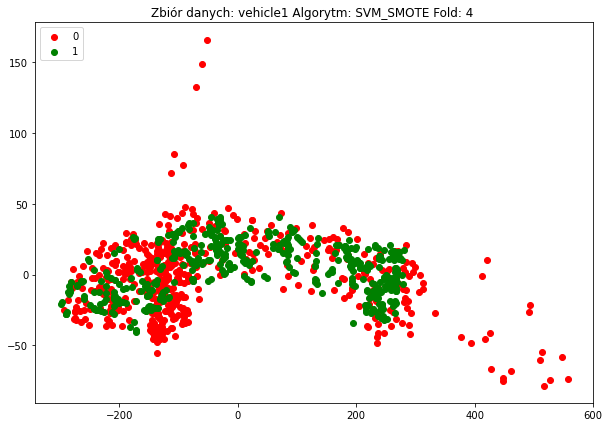

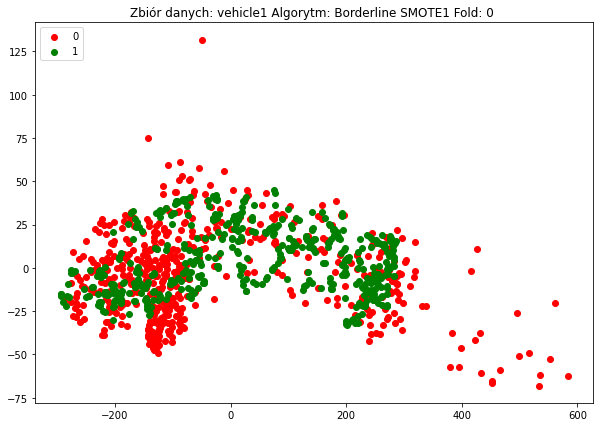

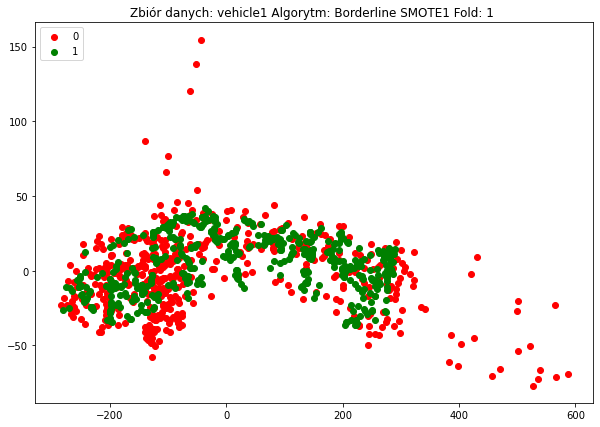

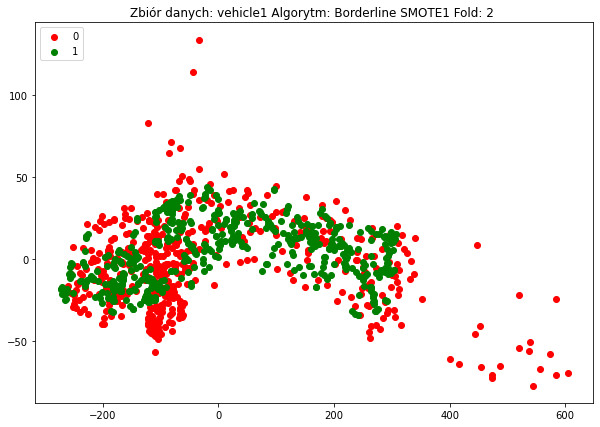

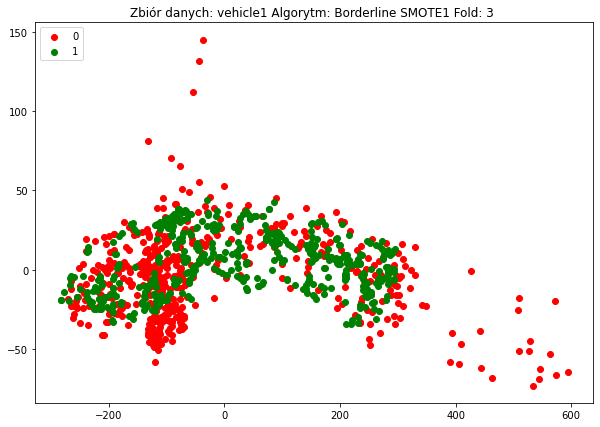

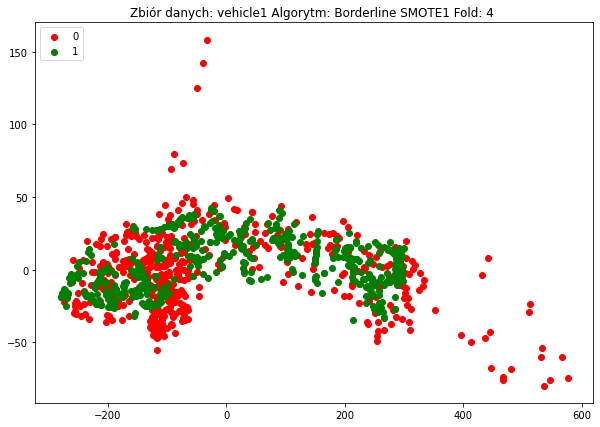

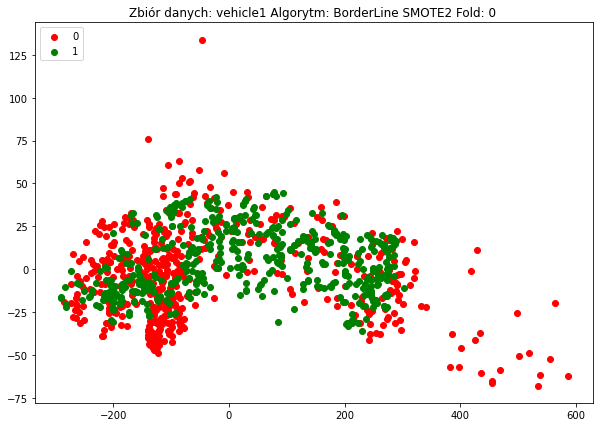

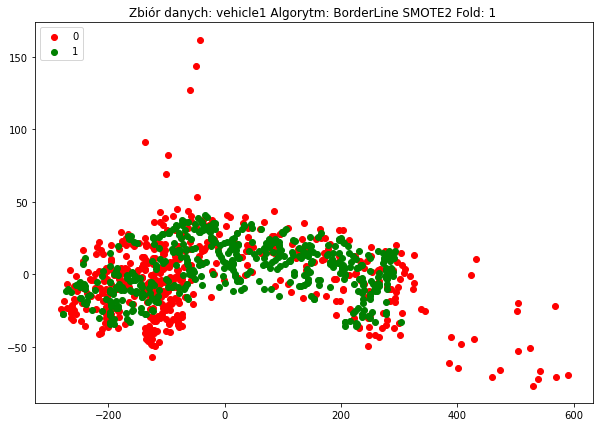

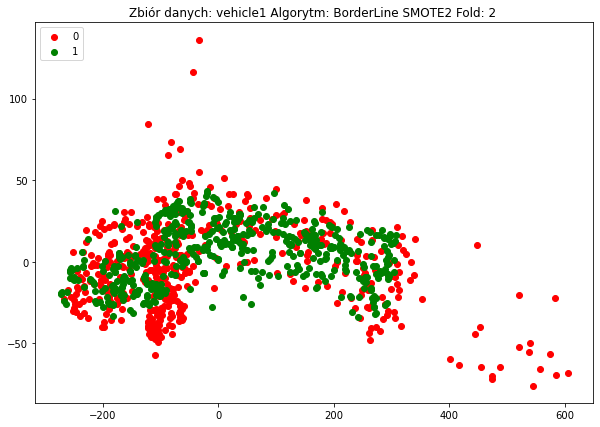

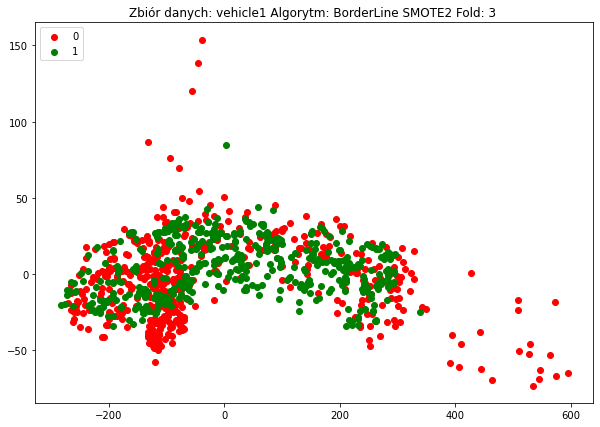

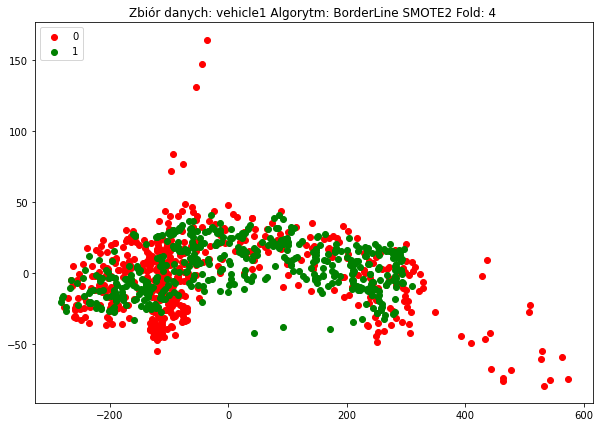

In [49]:
for dataset_path, dataset_name in zip(dataset_paths, dataset_names):
    data_df= pd.read_csv(dataset_path)
    target_names = data_df.iloc[:,-1].unique()
    dataset_stats_df = pd.DataFrame(columns=['Rodzaj zbioru', '1', '0'])
    X = data_df.drop(data_df.columns[-1], axis=1).to_numpy()
    y = data_df.loc[:, data_df.columns[-1]].to_numpy()
    X_decreased = decrease_dimension(X)
    plot_decrease_dimension(X_decreased, y, dataset_name, "Oryginalne dane", "imbalanced_original")
    df_y = numpy_to_pandas(y)
    dataset_stats_df = dataset_stats(df_y, dataset_stats_df, "Oryginalny zbior danych", dataset_name)
    target_names = data_df.iloc[:,-1].unique()
    X_decreased = decrease_dimension(X)
    metrics_imbalanced, dataset_stats_df = cross_validation_raw_data(X, y, dataset_name, None, dataset_stats_df)
    print("********IMBALANCED METRICS********")
    print('\n')
    print(f"Metrics for dataset: {dataset_name} \n")
    print_metrics(metrics_imbalanced)
    multiindex = create_multiindex(oversampler_dict.keys())
    result_dataframe = create_metrics_dataframe(multiindex)
    result_df = create_metrics_summary(metrics_imbalanced, result_dataframe, "Imbalanced")
    print("\n")
    print("********BALANCED METRICS******** \n")
    for oversampl_key in oversampler_dict.keys():
        print(f"DATASET: {dataset_name.upper()}")
        print(f"OVERSAMPLING METHOD: {oversampl_key}\n")
        metrics_balanced, dataset_stats_df = cross_validation_raw_data(X, y, dataset_name, oversampl_key, dataset_stats_df)
        print_metrics(metrics_balanced)
        result_df = create_metrics_summary(metrics_balanced, result_dataframe, oversampl_key)
    dataset_stats_df.to_csv(os.path.join(save_dir, f"{dataset_name}_dataset_stats.csv"))
    result_df.to_csv(os.path.join(save_dir, f"{dataset_name}_5_cross_validation_results.csv"))